In [1]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import sklearn.cluster as skclust 
import copy
import scipy.stats as spstat

def load_all_fitnesses(filename,obj) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fitnesses = []
        best_ind_id = []
        avg_fitnesses = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = 0
            best_id = 0
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i+obj]) > best_fitness) :
                    best_fitness = float(row[i+obj])
                    best_id = int(i/int(row[2]) - 1)
                avg_fitness += float(row[i+obj])
            avg_fitness = avg_fitness/float(row[1])
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_fitness)
            best_ind_id.append(best_id)
            nb_eval.append(nb_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, best_ind_id, best_fitnesses, avg_fitnesses, pop_size

def load_ind_fitnesses(filename,obj):
    with open(filename) as file:
        csv_data = csv.reader(file,delimiter=',')
        lines = []
        for row in csv_data:
            for i in range(3,len(row[:-1]),int(row[2])):
                lines.append([int(row[0]),i-3,float(row[i+obj])])
    return lines

def load_controller_archive(filename):
    lines = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        coord = [0]*3
        state = 0
        nbr_param = 0
        i=0
        for row in csv_data:
            if(len(row) == 3):
                coord[0] = int(row[0])
                coord[1] = int(row[1])
                coord[2] = int(row[2])
                state = 1
                i=0
            elif(state == 1):
                nbr_param = int(row[0])
                state = 2
            elif(state == 2):
                nbr_param += int(row[0])
                state = 3
            elif(state == 3 and i < nbr_param):
                i+=1
            elif(state == 3 and i >= nbr_param):
                lines.append([coord[0],coord[1],coord[2],float(row[0])])
    return pd.DataFrame(data=lines,columns=["number of wheels","number of joints","number of sensors","fitness"])
                
def load_number_of_eval_per_gen(foldername,nbr_gen,desc_size):
    nbr_eval_per_gen = [0]*nbr_gen
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            nbr_eval = 0
            for row in csv_data:
                if(len(row) == desc_size + 1):
                    nbr_eval+=1
        nbr_eval_per_gen[gen] += nbr_eval
   # for i in range(1,len(nbr_eval_per_gen)):
    #    nbr_eval_per_gen[i] += nbr_eval_per_gen[i-1]
    return nbr_eval_per_gen
    
def load_controllers_fitnesses(foldername,nbr_gen):
    init_fits = [[] for _ in range(nbr_gen)]
    best_fits = [[] for _ in range(nbr_gen)]
    learn_prog = [[] for _ in range(nbr_gen)]
    learn_delta = [[] for _ in range(nbr_gen)]
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            best_fit = 0
            init_fit = 0
            counter = 0
            for row in csv_data:
                if(len(row) == 3):
                    if(init_fit == 0):
                        init_fit = float(row[0])
                        if(init_fit < 0):
                            init_fit = 0.5
                    if(best_fit < float(row[0])):
                        best_fit = float(row[0])
                    counter+=1
            if(counter == 0):
                continue
            learn_prog[gen].append((best_fit - init_fit))
            learn_delta[gen].append((best_fit - init_fit)/counter)
            best_fits[gen].append(best_fit)
            init_fits[gen].append(init_fit)
            
        
    return best_fits, init_fits ,learn_delta, learn_prog    
    
    
def load_descriptor(filename) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(len(row)-1) :
                desc.append(float(row[i]))
            descriptors.append(desc)
        return descriptors
    
def descOneId_to_descTwoIds(descriptors,pop_size):
    descriptors2 = []
    gen = 0
    ind = 0
    for desc in descriptors:
        if(desc[0] != 0 and desc[0]%pop_size == 0):
            gen+=1
            ind=0
        desc2 = [gen,ind] + desc[1:]
        ind+=1
        descriptors2.append(desc2)
    return descriptors2
        
def descriptors_to_nbr_of_types(descriptors):
    types_lines = []
    acc = 0
    mat = [[[0 for _ in range(16)] for _ in range(16)] for _ in range(16)]
    for desc in descriptors:
        if(mat[int(desc[6]*16)][int(desc[7]*16)][int(desc[8]*16)] == 0):
            mat[int(desc[6]*16)][int(desc[7]*16)][int(desc[8]*16)] = 1
            acc+=1
        if(desc[1] == 0):
            type_lines.append([desc[0],acc])
    return type_lines

def sparsness_per_gen(descriptors,pop_size):
    sparsness = []
    for i in range(int(len(descriptors)/pop_size)):
        tmp_desc = descriptors[i*pop_size:(i+1)*pop_size]
        spars = 0
        for o in range(len(tmp_desc)):
            for p in range(len(tmp_desc)):
                if(o==p):
                    continue
                dist = np.linalg.norm(np.array(tmp_desc[o][3:])-np.array(tmp_desc[p][3:]))
            spars += dist
        sparsness.append([i,spars/10])
    return sparsness

def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

def plot_hist_nbr_rob(title,data,organ,bins,nb_rob):
    fig = plt.gcf()
    fig.set_size_inches(25,10)
    ax = sns.histplot(data=data,multiple="stack",bins=bins,x='gen',hue=organ,palette="light:b")
    ax.set_ylabel("Number of robots",fontsize=20)
    ax.set_xlabel("Generations",fontsize=20)
    plt.title(title,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(range(1,nb_rob+1),labels=[1]*nb_rob,fontsize=20)
    plt.show()
    
    
def acc_number_eval(nbr_eval, best_fit):
    acc_nbr_eval = [0]
    for ne in nbr_eval:
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
#    for ne,fit in zip(acc_nbr_eval,best_fit):
        #if(fit >= 0.95):
    return acc_nbr_eval, ne
        
def fitness_per_descriptor(descriptors,fitnesses,ngen):
    fit_per_desc = [dict() for _ in range(int(len(fitnesses)/gen))]
    for fit,desc in zip(fitnesses,descriptors):
        if(fit[0] == desc[0] and fit[1] == desc[1]):
            organ_desc = str(int(desc[6]*16))+str(int(desc[7]*16)) + str(int(desc[8]*16))
            if(organ_desc in fit_per_desc[fit[0]]):
                fit_per_desc[fit[0]][organ_desc].append(fit[2])
            else:
                fit_per_desc[fit[0]][organ_desc] = [fit[2]]
    return fit_per_desc

def best_desc_per_gen(descriptors,fitnesses):
    best_fit = 0
    best_idx = 0
    best_desc = []
    for fit,i in zip(fitnesses,range(len(fitnesses))):
        if(fit[1] == 0 and fit[0] != 0):
            best_fit = 0
            best_desc.append([fit[0],int(descriptors[best_idx][6]*16),int(descriptors[best_idx][7]*16),int(descriptors[best_idx][8]*16)])         
        if(fit[2] > best_fit):
            best_fit = fit[2]
            best_idx = i
        
    best_desc.append([fitnesses[-1][0]+1,int(descriptors[best_idx][6]*16),int(descriptors[best_idx][7]*16),int(descriptors[best_idx][8]*16)])         
    return best_desc
                     
def load_traj_of_gen(foldername,gen):
    trajectories = []
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "traj"):
            continue
        if(int(filename.split('_')[1]) != gen):
            continue
        x = []
        y = []
        with open(foldername + '/' + filename) as file:
            lines = file.readlines()
            for line in lines:
                str_pos = line.split(';')[0].split(',')
                x.append(float(str_pos[0]))
                y.append(float(str_pos[1]))
        trajectories.append([x,y])
    return trajectories


# Obstacle Avoidance

In [8]:
nb_eval_lines = []

In [9]:
arena="Obstacles"
exp_folder = "/home/leni/are-logs/mnipes_obst_tcds_2/200/wa/"
exp_folder_na = "/home/leni/are-logs/mnipes_obst_tcds_2/200/na/"

In [10]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit),64)
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 200",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    #descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    #fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    #for i in range(len(fitnesses)):
    #    fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    #fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
          #  organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
           # if(organ_desc in fit_per_desc[gen_v[-1]]):
            #    for fit in fit_per_desc[gen_v[-1]][organ_desc]:
             #       diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        #fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    #fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,ane,ne,ld,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,acc_nbr_eval,nbr_eval,learn_delta, learn_prog):
        lines.append([gen+1,
                      (gen+1)*25*200,
                      bf*64,
                      np.mean(initf)*64,
                      np.max(initf)*64,
                      af,
                      ane,
                      nc,
                      np.mean(cf)*64,
                      np.max(cf)*64,
                      ne,
                      np.mean(ld),
                      np.max(ld),
                      np.mean(lp)*64,
                      np.max(lp)*64])


wa_dc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average archive controllers fitness",
                                              "best archive controllers fitness",
                                              "number of evaluations",
                                              "average learning delta",
                                              "best learning delta",
                                              "average learning progress",
                                              "best learning progress"])

mnipes_7_7_16-34-36-6557-2313662223
20
91140
mnipes_12_7_9-53-13-3481-2761545328
20
94420
mnipes_7_7_16-34-54-4385-4085249635
20
91080
mnipes_15_6_8-28-33-3797-179460620
20
94260
mnipes_12_7_9-53-14-4786-23435155
20
93250
mnipes_12_7_9-53-9-9390-3753606683
20
92180
mnipes_13_6_12-24-34-4349-3901649069
20
86490
mnipes_12_7_9-53-12-2557-1191335460
20
96340
mnipes_12_7_10-9-5-5165-2176247729
20
89620
mnipes_15_6_8-28-34-4282-953524547
20
93950
mnipes_15_6_8-28-39-9381-760657556
20
90970
mnipes_12_6_16-28-24-4194-337144942
20
89760
mnipes_12_6_16-26-9-9623-1026894017
19
86910
mnipes_7_7_16-34-51-1880-3742084958
20
87970
mnipes_12_6_16-25-58-8761-839792423
20
88500
mnipes_13_6_13-32-7-7940-456389947
20
90490
mnipes_12_6_16-25-39-9556-2750828506
20
91470
mnipes_13_6_12-24-45-5226-2411165012
20
89500
mnipes_12_6_16-25-47-7473-1129280437
20
94140
mnipes_15_6_8-28-42-2784-3621491515
20
78510


In [ ]:
lines = []
for folder in os.listdir(exp_folder_na):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder_na + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder_na + folder,len(best_fit),64)
    
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"no archive 200",bff_ne,acc_nbr_eval[-1]])
    #fitnesses = load_ind_fitnesses(exp_folder_na + folder + "/fitnesses.csv")

    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder_na + folder + "/",len(best_fit))

    for gen, bf, initf, af,ane,ne,ld,lp in zip(range(len(best_fit)),best_fit,init_f,avg_fit,acc_nbr_eval,nbr_eval,learn_delta,learn_prog):
        lines.append([gen+1,
                      gen*2000,
                      bf*64,
                      np.mean(initf)*64,
                      np.max(initf)*64,
                      af,
                      ane,
                      ne,
                      np.mean(ld),
                      np.max(ld),
                      np.mean(lp)*64,
                      np.max(lp)*64])

na_dc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of evaluations",
                                              "average learning delta",
                                              "best learning delta",
                                              "average learning progress",
                                              "best learning progress"])


In [17]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",20)
    for initf, fit, ld,lp in zip(init_f, best_f, learn_delta,learn_prog):
        for i, f, d,p in zip(initf, fit, ld,lp):
            lines.append([i, f, d,p,"MELAI"])

mnipes_7_7_16-34-36-6557-2313662223
mnipes_12_7_9-53-13-3481-2761545328
mnipes_7_7_16-34-54-4385-4085249635
mnipes_15_6_8-28-33-3797-179460620
mnipes_12_7_9-53-14-4786-23435155
mnipes_12_7_9-53-9-9390-3753606683
mnipes_13_6_12-24-34-4349-3901649069
mnipes_12_7_9-53-12-2557-1191335460
mnipes_12_7_10-9-5-5165-2176247729
mnipes_15_6_8-28-34-4282-953524547
mnipes_15_6_8-28-39-9381-760657556
mnipes_12_6_16-28-24-4194-337144942
mnipes_12_6_16-26-9-9623-1026894017
mnipes_7_7_16-34-51-1880-3742084958
mnipes_12_6_16-25-58-8761-839792423
mnipes_13_6_13-32-7-7940-456389947
mnipes_12_6_16-25-39-9556-2750828506
mnipes_13_6_12-24-45-5226-2411165012
mnipes_12_6_16-25-47-7473-1129280437
mnipes_15_6_8-28-42-2784-3621491515


In [18]:
for folder in os.listdir(exp_folder_na):
    print(folder)
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder_na + folder + "/",20)
    for initf, fit, ld,lp in zip(init_f, best_f, learn_delta,learn_prog):
        for i, f, d,p in zip(initf, fit, ld,lp):
            lines.append([i, f, d,p,"MEL"])
dc_data2 = pd.DataFrame(data=lines, columns=["initial fitness","fitness", "learning delta","learning progress","type"])

mnipes_15_6_8-29-31-1764-1832410916
mnipes_12_6_16-29-21-1845-1399224667
mnipes_13_7_1-37-28-8754-1000596231
mnipes_13_7_1-37-54-4915-3983545084
mnipes_13_7_10-36-38-8174-816134334
mnipes_13_7_10-36-20-53-3965268341
mnipes_12_6_16-29-12-2964-836164609
mnipes_15_6_8-29-35-5276-2097030320
mnipes_12_6_18-51-44-4106-3601123297
mnipes_8_7_6-10-34-4188-3346270876
mnipes_15_6_8-29-35-5828-2084457589
mnipes_13_7_11-37-31-1827-4089961118
mnipes_12_6_16-29-35-5178-450775411
mnipes_12_6_16-29-10-580-2199323801
mnipes_12_6_16-29-19-9962-961984158
mnipes_8_7_7-16-52-2865-129236247
mnipes_12_6_16-29-14-4030-2289057423
mnipes_15_6_8-29-40-462-1402343982
mnipes_7_7_17-40-57-7041-1578563590
mnipes_7_7_20-8-43-3515-3172949793
mnipes_12_6_19-36-59-9950-2663912459


## controller archive dynamics

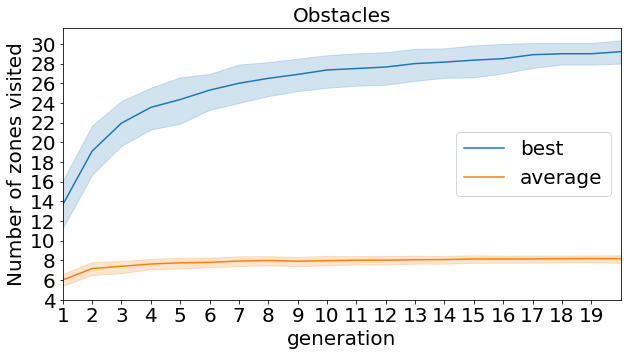

In [7]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_dc_data,x="generation",y="best archive controllers fitness",label="best")
sns.lineplot(data=wa_dc_data,x="generation",y="average archive controllers fitness",label="average")
ax.set_ylabel("Number of zones visited")
ax.set_xlim([1,20])
ax.set_xticks(range(1,20))
ax.set_yticks(range(4,31,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

(array([10, 20, 30, 40, 50, 60]), <a list of 6 Text yticklabel objects>)

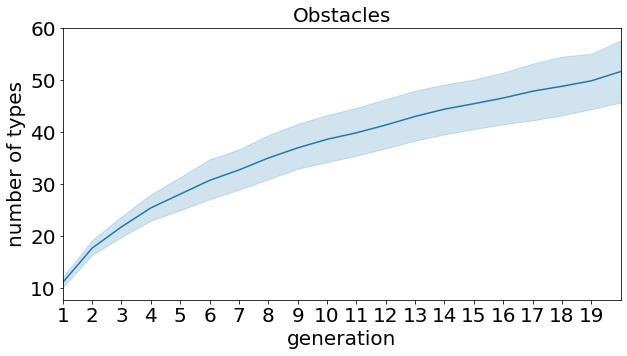

In [11]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_dc_data,x="generation",y="number of controllers")
ax.set_ylabel("number of types")
ax.set_xlim([1,20])
ax.set_xticks(range(1,20))
ax.set_yticks(range(10,61,10))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## Performance of solutions and Efficiency of Algorithm

420


Text(2, 12, 'Statistic : 55.5\np : 2.63e-05')

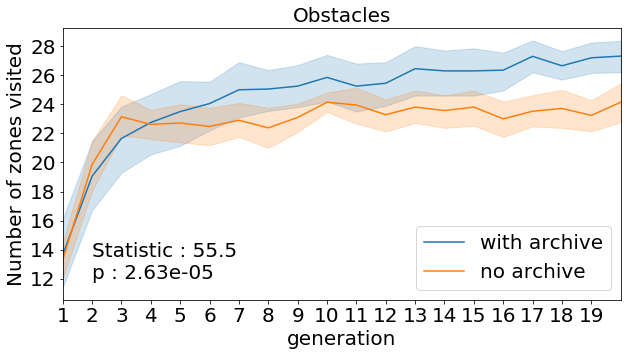

In [12]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_dc_data,x="generation",y="best fitness",label="with archive")
sns.lineplot(data=na_dc_data,x="generation",y="best fitness",label="no archive")
ax.set_ylabel("Number of zones visited")
ax.set_xlim([1,20])
ax.set_xticks(range(1,20))
ax.set_yticks(range(12,29,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
d1 = wa_dc_data[wa_dc_data["generation"]==19]["best fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["best fitness"].to_numpy()
print(len(d1)*len(d2))
U1, p = spstat.mannwhitneyu(d1,d2)
stat = "Statistic : " + str(U1) + "\np : " + str(round(p,7))
plt.text(2,12,stat,fontsize=20)

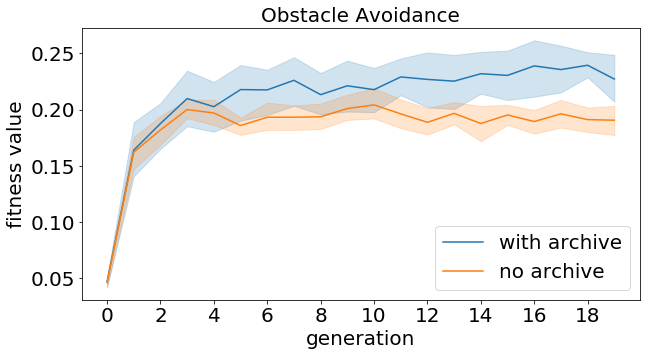

In [9]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_dc_data,x="generation",y="average fitness",label="with archive")
sns.lineplot(data=na_dc_data,x="generation",y="average fitness",label="no archive")
ax.set_ylabel("fitness value")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

420
MannwhitneyuResult(statistic=7.0, pvalue=5.8087884458497736e-08)
420
MannwhitneyuResult(statistic=0.0, pvalue=2.3220802589496242e-08)


Text(8, 5, 'Statistic : 0.0 p : 2.32e-08')

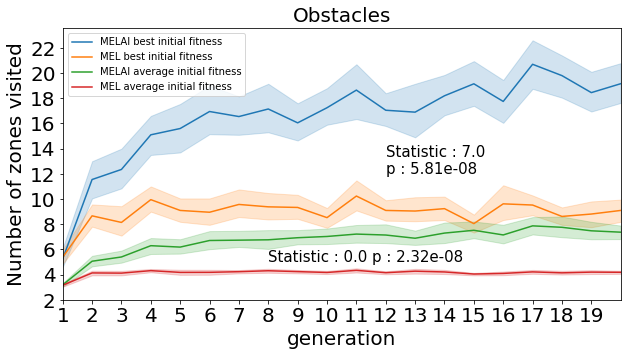

In [13]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best initial fitness",label="MELAI best initial fitness")
sns.lineplot(data=na_dc_data,x="generation",y="best initial fitness",label="MEL best initial fitness")
sns.lineplot(data=wa_dc_data,x="generation",y="average initial fitness",label="MELAI average initial fitness")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average initial fitness",label="MEL average initial fitness")
ax.set_xlim([1,20])
ax.set_xticks(range(1,20))
ax.set_yticks(range(2,24,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("Number of zones visited")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(fontsize=10,bbox_to_anchor=(1.,0.5,0,0))
d1 = wa_dc_data[wa_dc_data["generation"]==19]["best initial fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["best initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
U1, p = spstat.mannwhitneyu(d1,d2)
stat = "Statistic : " + str(U1) + "\np : " + str(round(p,10))
plt.text(12,12,stat,fontsize=15)
d1 = wa_dc_data[wa_dc_data["generation"]==19]["average initial fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["average initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
U1, p = spstat.mannwhitneyu(d1,d2)
stat = "Statistic : " + str(U1) + " p : " + str(round(p,10))
plt.text(8,5,stat,fontsize=15)

420
MannwhitneyuResult(statistic=188.5, pvalue=0.29120834443041427)


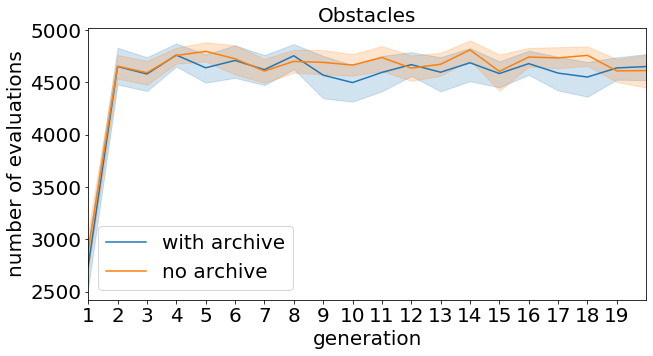

In [14]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xlim(1,20)
ax.set_xticks(range(1,20))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
d1 = wa_dc_data[wa_dc_data["generation"]==19]["number of evaluations"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["number of evaluations"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

420
MannwhitneyuResult(statistic=183.0, pvalue=0.24278659006647518)


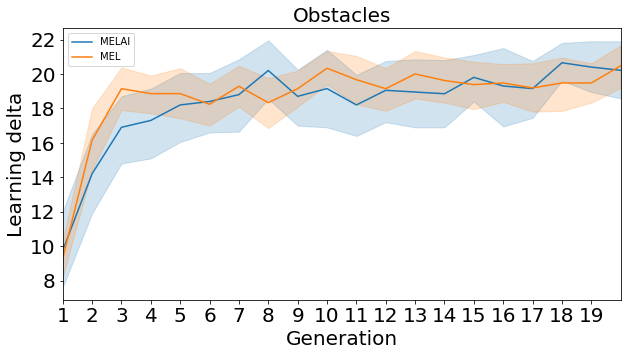

In [15]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best learning progress",label="MEL")
d1 = wa_dc_data[wa_dc_data["generation"]==19]["best learning progress"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["best learning progress"].to_numpy()
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_xlim(1,20)
ax.set_xticks(range(1,20))
ax.set_ylabel("Learning delta")
ax.set_xlabel("Generation")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title(arena,fontsize=20)
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

<Figure size 2160x2880 with 0 Axes>

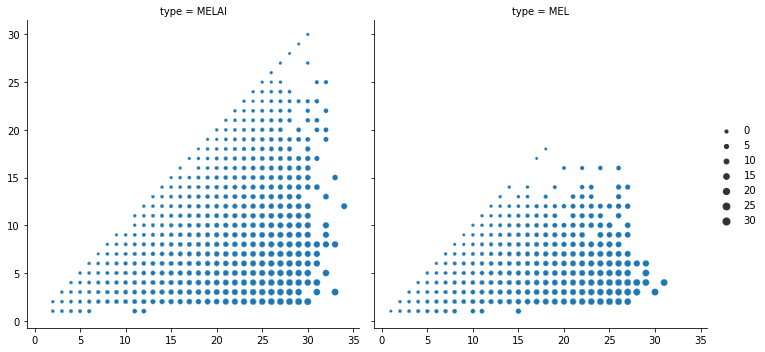

In [107]:
fig = plt.gcf()
fig.set_size_inches(30, 40)
g = sns.FacetGrid(data=dc_data2,col="type",height=5)
g.map_dataframe(sns.scatterplot,x="fitness",y="initial fitness",size="learning progress",sizes=(10,50))
g.add_legend()
#ax.xaxis.label.set_size(20)
#ax.yaxis.label.set_size(20)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
#ax.set_title(arena,fontsize=20)

Text(0.5, 0.98, 'Obstacles')

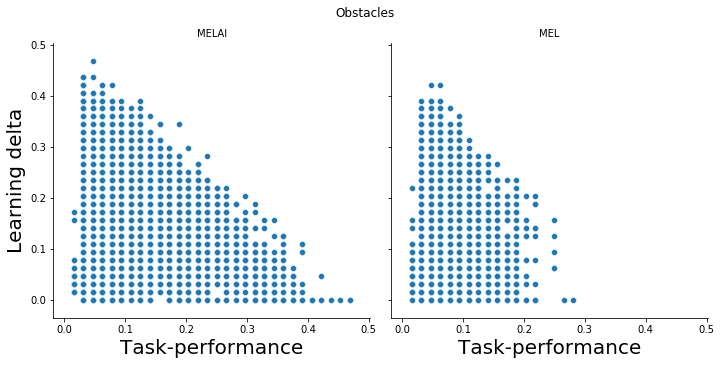

In [20]:
g = sns.FacetGrid(data=dc_data2,col="type",height=5)
g.map_dataframe(sns.scatterplot,x="initial fitness",y="learning progress")
g.set_xlabels("Task-performance",fontsize=20)
g.set_ylabels("Learning delta",fontsize=20)
g.set_titles("{col_name}",fontsize=40)
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle(arena)

## Diversity of Robots 

In [73]:
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    #if(fit[2] >= 0.5):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MELAI",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MELAI",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MELAI",arena])

In [74]:
fit_lines_na = []
desc_lines_na = []
type_lines_na = []
best_desc_lines_na = []
for folder in os.listdir(exp_folder_na):
    descriptors = load_descriptor(exp_folder_na + folder + "/MD_Cart_WDH.csv")
    type_lines_na += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder_na + folder + "/fitnesses.csv",0)
    fit_lines_na += fitnesses
    best_desc_lines_na += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines_na.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines_na,desc_lines_na):
    #if(fit[2] >= 0.5):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL",arena])

### Total robots set produced

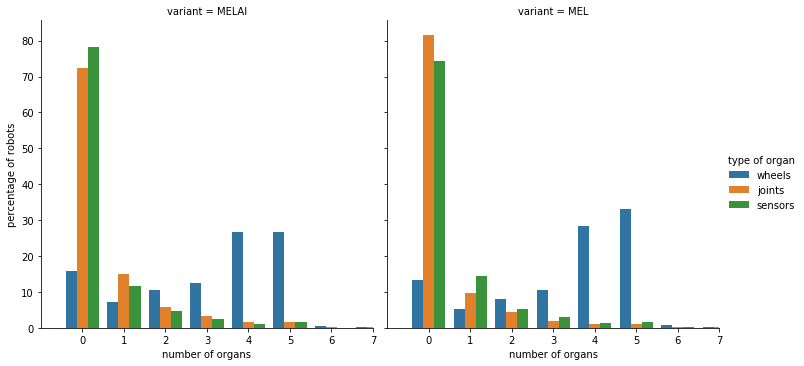

In [16]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

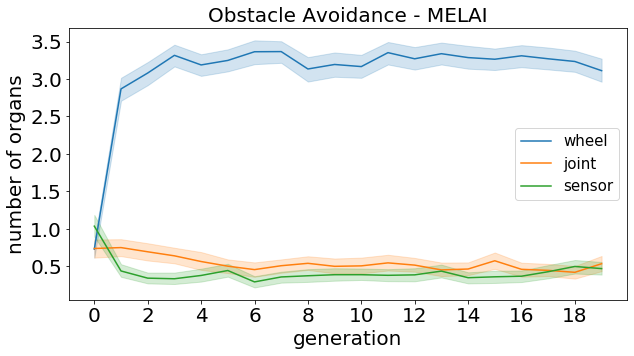

In [17]:
data = pd.DataFrame(data=desc_lines,columns=["generation","individual","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xticks(range(0,20,2))
#ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MELAI",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

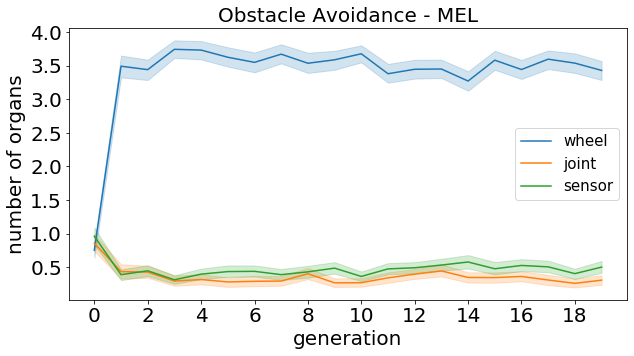

In [18]:
data = pd.DataFrame(data=desc_lines_na,columns=["generation","individual","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xticks(range(0,20,2))
#ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MEL",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

### Best descriptor per gen

[[5, 0, 0], [4, 0, 0], [4, 0, 0], [5, 0, 0], [3, 1, 0], [4, 0, 0], [4, 0, 1], [4, 1, 0], [4, 1, 0], [4, 1, 0], [5, 0, 0], [4, 0, 0], [5, 0, 0], [4, 0, 1], [5, 0, 0], [4, 0, 0], [4, 1, 0], [5, 0, 0], [4, 0, 1], [4, 0, 0]]


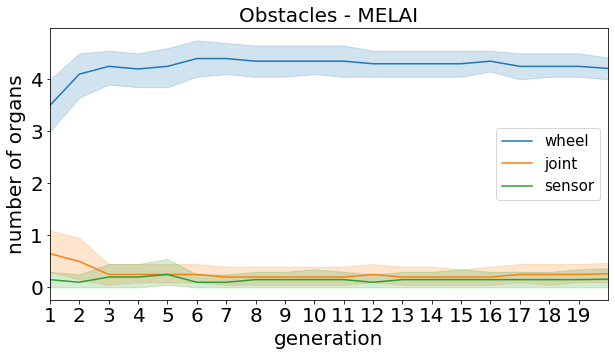

In [75]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xlim(1,20)
ax.set_xticks(range(1,20))
#ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MELAI",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==18]["wheel"].values
joints_array = data.loc[data["generation"]==18]["joint"].values
sensors_array = data.loc[data["generation"]==18]["sensor"].values
bda = [[w,j,s]for w,j,s in zip(wheels_array,joints_array,sensors_array)]
print(bda)

[[4, 1, 0], [5, 0, 0], [4, 0, 1], [4, 0, 1], [4, 0, 0], [4, 0, 1], [5, 0, 0], [4, 0, 0], [4, 0, 0], [5, 0, 0], [4, 0, 1], [4, 0, 0], [4, 1, 0], [4, 0, 1], [5, 0, 0], [5, 0, 0], [4, 0, 0], [4, 0, 0], [6, 0, 0], [4, 0, 1], [5, 0, 0]]


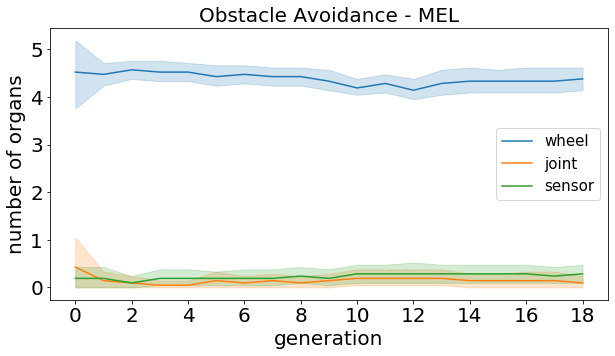

In [20]:
data = pd.DataFrame(data=best_desc_lines_na,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xticks(range(0,20,2))
#ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MEL",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==18]["wheel"].values
joints_array = data.loc[data["generation"]==18]["joint"].values
sensors_array = data.loc[data["generation"]==18]["sensor"].values
bda = [[w,j,s]for w,j,s in zip(wheels_array,joints_array,sensors_array)]
print(bda)

## Trajectories

mnipes_12_6_16-28-24-4194-337144942


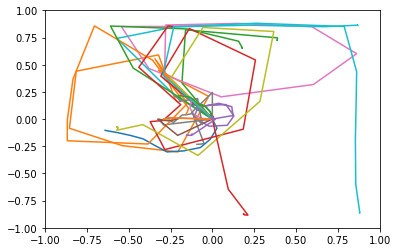

mnipes_12_6_16-25-58-8761-839792423


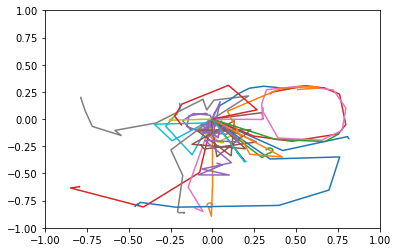

mnipes_12_6_16-25-39-9556-2750828506


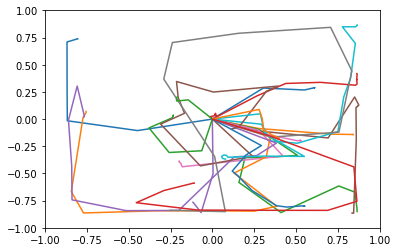

mnipes_12_6_16-25-47-7473-1129280437


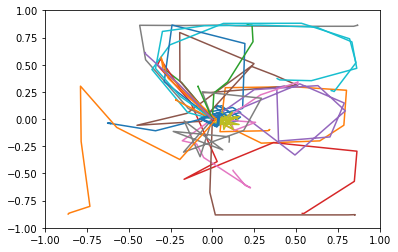

In [26]:
for folder in os.listdir(exp_folder):
    print(folder)
    trajs = load_traj_of_gen(exp_folder + '/' + folder,19)
    for traj in trajs:
        plt.plot(traj[0],traj[1],)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.show()

mnipes_12_6_16-29-21-1845-1399224667


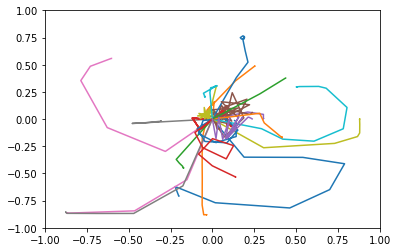

mnipes_12_6_16-29-12-2964-836164609


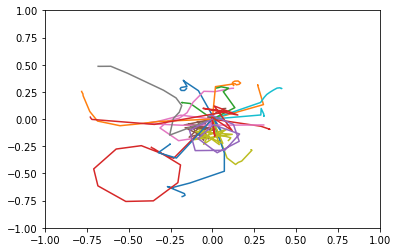

mnipes_12_6_18-51-44-4106-3601123297


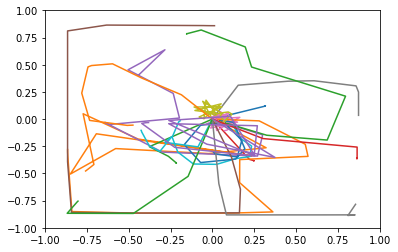

mnipes_12_6_16-29-35-5178-450775411


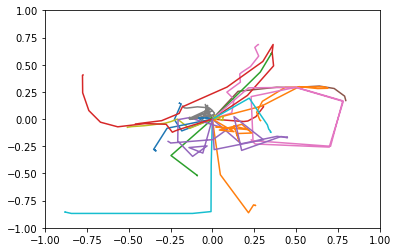

mnipes_12_6_16-29-10-580-2199323801


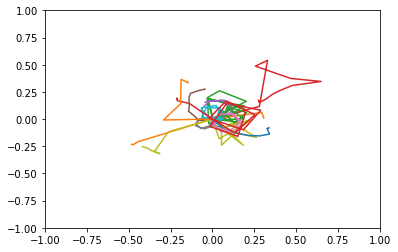

mnipes_12_6_16-29-19-9962-961984158


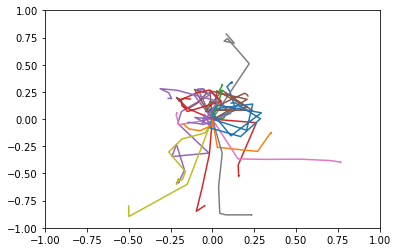

mnipes_12_6_16-29-14-4030-2289057423


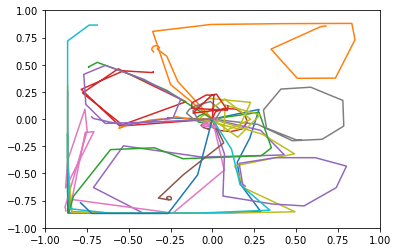

mnipes_12_6_19-36-59-9950-2663912459


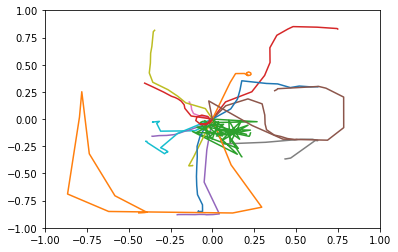

In [27]:
for folder in os.listdir(exp_folder_na):
    print(folder)
    trajs = load_traj_of_gen(exp_folder_na + '/' + folder,19)
    for traj in trajs:
        plt.plot(traj[0],traj[1],)
    plt.xlim([-1,1])
    plt.ylim([-1,1])

    plt.show()

## Budget Comparison

In [53]:
folder_100 = "/home/leni/are-logs/mnipes_obst_tcds_2/100/"
folder_150= "/home/leni/are-logs/mnipes_obst_tcds_2/150/"
folder_400= "/home/leni/are-logs/mnipes_obst_tcds_2/400/"
folder_800= "/home/leni/are-logs/mnipes_obst_tcds_2/800/"

In [54]:
lines = []
for folder in os.listdir(folder_100):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(folder_100 + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(folder_100 + folder,len(best_fit),64)
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 100",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(folder_100 + folder + "/",len(best_fit))
   # descriptors = load_descriptor(folder_100 + folder + "/MD_Cart_WDH.csv")
   # fitnesses = load_ind_fitnesses(folder_100 + folder + "/fitnesses.csv",0)
    #for i in range(len(fitnesses)):
    #    fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    #fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(folder_100 + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(folder_100 + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
          #  organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
           # if(organ_desc in fit_per_desc[gen_v[-1]]):
            #    for fit in fit_per_desc[gen_v[-1]][organ_desc]:
             #       diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        #fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    #fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      (gen+1)*25*100,
                      bf*64,
                      np.mean(initf),
                      np.max(initf),
                      af,
                      ane,
                      nc,
                      np.mean(cf),
                      np.max(cf),
                      ne,
                      np.mean(lp),
                      np.max(lp)])
wa_c_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average archive controllers compatibility",
                                              "best archive controllers compatibility",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

mnipes_12_7_9-54-28-8445-954822700
40
0
mnipes_10_7_8-49-1-1039-3727372926
40
0
mnipes_18_6_12-9-43-3245-1617509046
40
0
mnipes_18_6_12-9-46-6732-3549354290
40
0
mnipes_12_7_11-17-37-7485-3818996471
40
0
mnipes_12_7_9-54-17-7254-102654152
40
0
mnipes_18_6_12-9-56-6967-2382099558
40
0
mnipes_18_6_12-9-59-9339-1697284309
40
0
mnipes_18_6_12-10-20-257-4052458325
40
0
mnipes_18_6_12-10-28-8288-2918170652
40
0
mnipes_18_6_12-10-14-4120-3467866409
40
0
mnipes_12_7_11-58-34-4353-1046162386
40
0
mnipes_10_7_8-48-55-5402-2285776304
40
0
mnipes_12_7_9-54-27-7518-429468230
40
0
mnipes_10_7_8-48-56-6827-4243397068
40
0
mnipes_18_6_12-10-1-1324-4139723185
40
0
mnipes_10_7_8-48-53-3391-234571381
40
0
mnipes_18_6_12-9-58-8141-109661765
40
0
mnipes_18_6_12-10-1-1117-1603763126
40
0
mnipes_10_7_8-49-6-6590-1530688870
40
0


In [57]:
lines = []
for folder in os.listdir(folder_150):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(folder_150 + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(folder_150 + folder,len(best_fit),64)
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 150",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(folder_150 + folder + "/",len(best_fit))
    descriptors = load_descriptor(folder_150 + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(folder_150 + folder + "/fitnesses.csv",0)
    #for i in range(len(fitnesses)):
    #    fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    #fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(folder_150 + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(folder_150 + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
          #  organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
           # if(organ_desc in fit_per_desc[gen_v[-1]]):
            #    for fit in fit_per_desc[gen_v[-1]][organ_desc]:
             #       diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        #fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    #fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      (gen+1)*25*150,
                      bf*64,
                      np.mean(initf),
                      np.max(initf),
                      af,
                      ane,
                      nc,
                      np.mean(cf),
                      np.max(cf),
                      ne,
                      np.mean(lp),
                      np.max(lp)])
wa_cc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average archive controllers compatibility",
                                              "best archive controllers compatibility",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

mnipes_4_7_13-58-40-134-2871411317
30
0
mnipes_12_7_23-5-33-3431-335589877
30
0
mnipes_4_7_13-58-43-3469-3618714994
30
0
mnipes_18_6_12-23-32-2266-1205293833
30
0
mnipes_12_7_17-6-42-2571-4224271946
30
0
mnipes_13_7_13-53-6-6454-3876657886
30
0
mnipes_16_7_11-10-36-6531-1385175540
30
0
mnipes_18_6_12-23-31-1407-3022198950
30
0
mnipes_12_7_19-25-3-3625-202134042
30
0
mnipes_4_7_13-58-39-9591-2685412583
30
0
mnipes_18_6_12-23-38-8367-3035427200
30
0
mnipes_10_7_8-49-35-5091-4115254748
30
0
mnipes_18_6_12-23-54-4316-2005985695
30
0
mnipes_10_7_8-49-40-326-1484920487
30
0
mnipes_13_7_1-25-31-1983-413168571
30
0
mnipes_10_7_8-49-38-8110-475644113
30
0
mnipes_10_7_8-49-35-5780-3681414779
30
0
mnipes_18_6_12-23-39-9101-1746126329
30
0
mnipes_18_6_12-23-45-5012-3669355058
30
0
mnipes_18_6_12-23-44-4012-2705722741
30
0


In [58]:
lines = []
for folder in os.listdir(folder_400):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(folder_400 + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(folder_400 + folder,len(best_fit),64)
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 400",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(folder_400 + folder + "/",len(best_fit))
    descriptors = load_descriptor(folder_400 + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(folder_400 + folder + "/fitnesses.csv",0)
    #for i in range(len(fitnesses)):
    #    fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    #fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(folder_400 + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(folder_400 + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
          #  organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
           # if(organ_desc in fit_per_desc[gen_v[-1]]):
            #    for fit in fit_per_desc[gen_v[-1]][organ_desc]:
             #       diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        #fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    #fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      (gen+1)*25*400,
                      bf*64,
                      np.mean(initf),
                      np.max(initf),
                      af,
                      ane,
                      nc,
                      np.mean(cf),
                      np.max(cf),
                      ne,
                      np.mean(lp),
                      np.max(lp)])
wa_qc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average archive controllers compatibility",
                                              "best archive controllers compatibility",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

mnipes_10_7_8-50-32-2228-2530506178
10
0
mnipes_10_7_8-50-17-7416-1376401146
10
0
mnipes_4_7_13-59-40-822-987065921
10
0
mnipes_23_7_15-30-4-4581-3448740256
10
0
mnipes_23_7_15-30-3-3446-3189417772
10
0
mnipes_4_7_13-59-23-3524-1812640003
10
0
mnipes_21_6_11-31-52-2662-2683584806
10
0
mnipes_4_7_13-59-26-6900-4103657112
10
0
mnipes_21_6_11-31-53-3196-3056894265
10
0
mnipes_4_7_13-59-25-5683-635868815
10
0
mnipes_21_6_11-31-40-940-3791880332
10
0
mnipes_23_7_15-30-3-3758-4285468857
10
0
mnipes_17_7_4-32-44-4413-2974291612
10
0
mnipes_10_7_8-50-21-1137-2771351640
10
0
mnipes_10_7_8-50-20-35-3316435747
10
0
mnipes_23_7_15-30-10-840-3360828441
10
0
mnipes_4_7_13-59-31-1651-741659690
10
0
mnipes_4_7_13-59-30-824-3038368451
10
0
mnipes_4_7_13-59-46-6805-3080016048
10
0
mnipes_16_7_11-11-8-8887-3384888966
10
0
mnipes_10_7_8-50-23-3262-3866512724
10
0
mnipes_4_7_13-59-47-7523-3362129528
10
0
mnipes_4_7_13-59-43-3665-449453338
10
0


In [66]:
lines = []
for folder in os.listdir(folder_800):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(folder_800 + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(folder_800 + folder,len(best_fit),64)
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 800",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(folder_800 + folder + "/",len(best_fit))
    descriptors = load_descriptor(folder_800 + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(folder_800 + folder + "/fitnesses.csv",0)
    #for i in range(len(fitnesses)):
    #    fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    #fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(folder_800 + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(folder_800 + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
          #  organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
           # if(organ_desc in fit_per_desc[gen_v[-1]]):
            #    for fit in fit_per_desc[gen_v[-1]][organ_desc]:
             #       diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        #fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    #fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,ane,ne,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,
                      (gen+1)*25*800,
                      bf*64,
                      np.mean(initf),
                      np.max(initf),
                      af,
                      ane,
                      nc,
                      np.mean(cf),
                      np.max(cf),
                      ne,
                      np.mean(lp),
                      np.max(lp)])
wa_hc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average archive controllers compatibility",
                                              "best archive controllers compatibility",
                                              "number of evaluations",
                                              "average learning progress",
                                              "best learning progress"])

mnipes_21_6_11-33-23-3069-3081306180
5
0


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

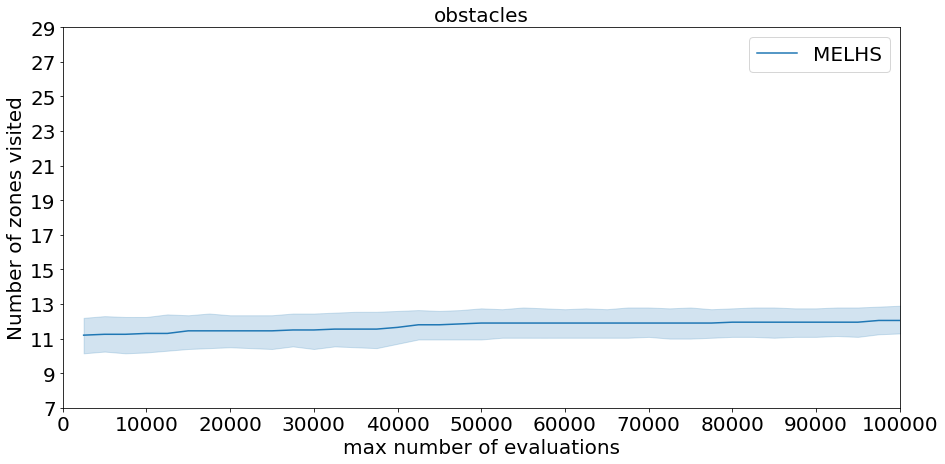

In [65]:
fig = plt.gcf()
fig.set_size_inches(15,7)
ax=sns.lineplot(data=wa_c_data,x="max number of evaluations",y="best fitness",label="[100,40]")
sns.lineplot(data=wa_cc_data,x="max number of evaluations",y="best fitness",label="[150,30]")
sns.lineplot(data=wa_dc_data,x="max number of evaluations",y="best fitness",label="[200,20]")
sns.lineplot(data=wa_qc_data,x="max number of evaluations",y="best fitness",label="[400,10]")
sns.lineplot(data=wa_hc_data,x="max number of evaluations",y="best fitness",label="[800,5]")
sns.lineplot(data=rd_data,x="max number of evaluations",y="best fitness",label="MELHS")
ax.set_ylabel("Number of zones visited")
ax.set_ylim(7,29)
ax.set_yticks(range(7,30,2))
ax.set_xticks(range(0,100001,10000))
ax.set_xlim(0,100000)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

## ME LHS

In [61]:
nb_eval_lines=[]

In [62]:
arena = "obstacles"
folder_melhs = "/home/leni/are-logs/me_lhs_obst/"

In [64]:
lines = []
for folder in os.listdir(folder_melhs):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(folder_melhs + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(folder_melhs + folder,len(best_fit),64)
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 100",bff_ne,acc_nbr_eval[-1]])
        
    for gen, bf, af,ane,ne in zip(range(len(best_fit)),best_fit,avg_fit,acc_nbr_eval,nbr_eval):
        lines.append([gen,
                      (gen+1)*25*100,
                      bf*64,
                      af,
                      ane,
                      ne])
rd_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of evaluations"])

me_lhs_24_7_15-24-48-8172-1971553191
41
me_lhs_24_7_15-25-34-4365-1778377147
41
me_lhs_24_7_15-25-33-3726-3385865308
41
me_lhs_24_7_15-24-40-799-2619102172
41
me_lhs_24_7_15-25-9-9758-1945794146
41
me_lhs_24_7_15-24-37-7426-3801734221
41
me_lhs_24_7_15-25-3-3274-2776230942
41
me_lhs_24_7_15-25-6-6245-2083310306
41
me_lhs_24_7_15-25-38-8748-210629431
41
me_lhs_24_7_15-25-12-2674-2863533707
41
me_lhs_24_7_15-25-29-9311-3552039122
41
me_lhs_24_7_15-25-5-5130-2971241078
41
me_lhs_24_7_15-26-2-2899-3458448425
41
me_lhs_24_7_15-25-28-8613-1299352390
41
me_lhs_24_7_15-25-46-6486-539741188
41
me_lhs_24_7_15-25-38-8735-2710523517
41
me_lhs_24_7_15-25-17-7594-449318192
41
me_lhs_24_7_15-24-44-4396-562497000
41
me_lhs_24_7_15-25-31-1330-475094722
41
me_lhs_24_7_15-26-1-1939-3886848237
41


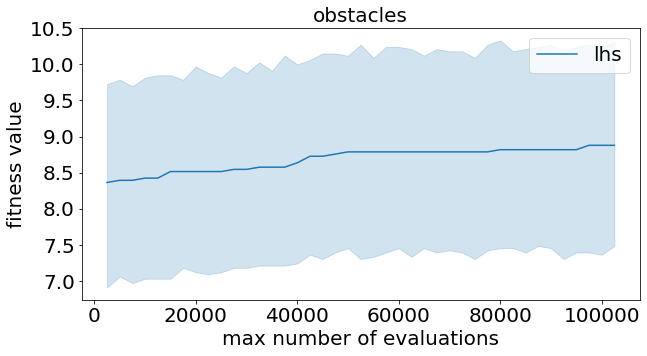

In [106]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=rd_data,x="max number of evaluations",y="best fitness",label="lhs")
ax.set_ylabel("fitness value")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

# Empty Arena

In [5]:
nb_eval_lines = []

In [6]:
arena="Arena"
exp_folder = "/home/leni/are-logs/mnipes_arena_multi_tcds/wa/"
exp_folder_na = "/home/leni/are-logs/mnipes_arena_multi_tcds/na/"

In [7]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit),3)
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 200",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    #descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    #fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    #for i in range(len(fitnesses)):
    #    fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    #fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
            organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
            #if(organ_desc in fit_per_desc[gen_v[-1]]):
            #    for fit in fit_per_desc[gen_v[-1]][organ_desc]:
            #        diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,ane,ne,ld,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,acc_nbr_eval,nbr_eval,learn_delta,learn_prog):
        lines.append([gen+1,
                      gen*25*200,
                      (1-bf)*math.sqrt(2**3),
                      (1-np.mean(initf))*math.sqrt(2**3),
                      (1-np.max(initf))*math.sqrt(2**3),
                      af,
                      ane,
                      nc,
                      (1-np.mean(cf))*math.sqrt(2**3),
                      (1-np.max(cf))*math.sqrt(2**3),
                      ne,
                      np.mean(ld),
                      np.max(ld),
                      np.mean(lp),
                      np.max(lp)])
wa_dc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average archive controllers fitness",
                                              "best archive controllers fitness",
                                              "number of evaluations",                                              
                                              "average learning delta",
                                              "best learning delta",
                                              "average learning progress",
                                              "best learning progress"])

mnipes_7_7_16-32-34-4021-702117173
15
49590
mnipes_13_6_9-44-33-3306-1169329975
15
49890
mnipes_7_7_16-32-26-6542-2097953184
15


KeyboardInterrupt: 

In [4]:
lines = []
for folder in os.listdir(exp_folder_na):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder_na + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder_na + folder,len(best_fit),3)
    
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"no archive 200",bff_ne,acc_nbr_eval[-1]])
            
    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder_na + folder + "/",len(best_fit))

    for gen, bf, initf, af,ane,ne,ld,lp in zip(range(len(best_fit)),best_fit,init_f,avg_fit,acc_nbr_eval,nbr_eval,learn_delta,learn_prog):
        lines.append([gen+1,
                      gen*2000,
                      (1-bf)*math.sqrt(2**3),
                      (1-np.mean(initf))*math.sqrt(2**3),
                      (1-np.max(initf))*math.sqrt(2**3),
                      af,
                      ane,
                      ne,
                      np.mean(ld),
                      np.max(ld),
                      np.mean(lp),
                      np.max(lp)])
na_dc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of evaluations",                                            
                                              "average learning delta",
                                              "best learning delta",
                                              "average learning progress",
                                              "best learning progress"])

mnipes_9_6_16-26-47-7162-4115342436
20
73900
mnipes_9_6_16-26-48-8885-1536227513
20


KeyboardInterrupt: 

In [25]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",20)
    for initf, fit, ld, lp in zip(init_f, best_f, learn_delta,learn_prog):
        for i, f, d,p in zip(initf, fit, ld,lp):
            lines.append([i, f, d,p,"MELAI"])

mnipes_7_7_16-32-34-4021-702117173
mnipes_13_6_9-44-33-3306-1169329975
mnipes_7_7_16-32-26-6542-2097953184
mnipes_11_7_1-52-36-6241-1004713848
mnipes_6_7_1-32-38-8684-2327107383
mnipes_6_7_0-52-5-5976-570627361
mnipes_13_6_8-57-50-458-1831229511
mnipes_13_6_0-33-37-7032-2993394491
mnipes_11_7_1-18-52-2283-545745368
mnipes_16_7_11-5-25-5361-2573479572
mnipes_16_7_11-5-26-6375-986796551
mnipes_7_7_16-30-13-3227-2410211677
mnipes_13_6_6-51-44-4634-2490326509
mnipes_13_6_7-5-52-2175-3777811018
mnipes_7_7_16-30-21-1784-3296453942
mnipes_13_6_9-4-7-7456-594596689
mnipes_13_6_9-30-19-9813-1085493925
mnipes_13_6_12-12-34-4224-3354611399
mnipes_11_7_1-37-24-4124-413599736
mnipes_16_7_11-5-27-7497-1584431645


In [26]:
for folder in os.listdir(exp_folder_na):
    print(folder)
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder_na + folder + "/",20)
    for initf, fit, ld,lp in zip(init_f, best_f, learn_delta,learn_prog):
        for i, f, d,p in zip(initf, fit, ld,lp):
            lines.append([i, f, d,p,"MEL"])
dc_data2 = pd.DataFrame(data=lines, columns=["initial fitness","fitness","learning delta", "learning progress","algorithm"])

mnipes_9_6_16-26-47-7162-4115342436
mnipes_9_6_16-26-48-8885-1536227513
mnipes_9_6_16-26-46-6474-187074767
mnipes_9_6_16-26-40-154-2618375502
mnipes_11_7_10-4-57-7403-36426883
mnipes_16_7_11-5-14-4553-2813448995
mnipes_9_6_16-26-53-3139-703778483
mnipes_5_7_11-4-41-1563-4132432126
mnipes_16_7_11-4-59-9528-1851856813
mnipes_16_7_11-4-52-2725-469247173
mnipes_5_7_10-43-46-6394-517613920
mnipes_9_6_16-26-58-8898-818282049
mnipes_9_6_16-26-40-215-1565307207
mnipes_9_6_16-26-45-5180-4252193311
mnipes_11_7_10-5-1-1631-1394334910
mnipes_11_7_3-26-11-1285-3265022875
mnipes_9_6_16-27-0-805-499610574
mnipes_5_7_15-1-26-6237-3167685919
mnipes_9_6_16-28-52-2321-1689524214
mnipes_16_7_11-4-59-9746-2148485246


## controller archive dynamics

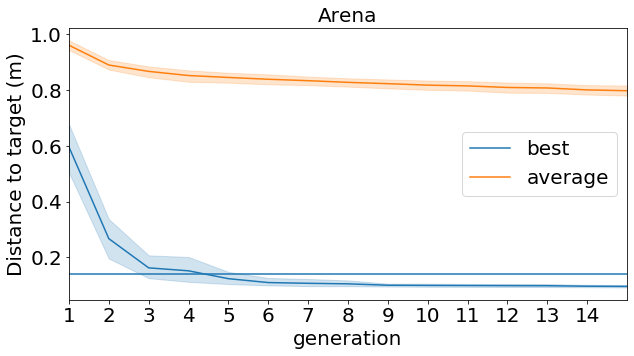

In [154]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_dc_data,x="generation",y="best archive controllers fitness",label="best")
sns.lineplot(data=wa_dc_data,x="generation",y="average archive controllers fitness",label="average")
ax.set_ylabel("Distance to target (m)")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15))
ax.axhline(y=0.05*math.sqrt(2**3))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

(array([10, 20, 30, 40, 50]), <a list of 5 Text yticklabel objects>)

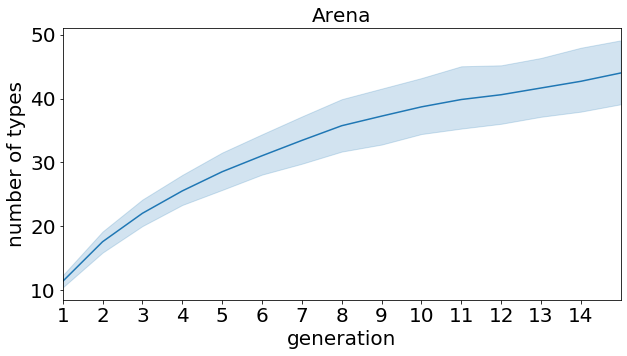

In [27]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_dc_data,x="generation",y="number of controllers")
ax.set_ylabel("number of types")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15))
ax.set_yticks(range(10,51,10))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## Performance of solutions and Efficiency of the Algorithms

380
MannwhitneyuResult(statistic=55.0, pvalue=7.869060034654935e-05)


Text(7, 0.4, 'Statistic : 55.0\np : 7.87e-05')

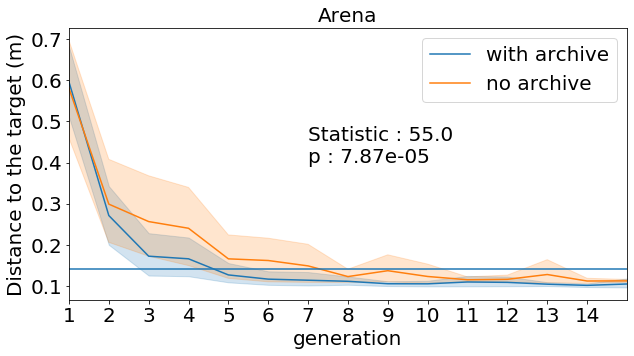

In [28]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_dc_data,x="generation",y="best fitness",label="with archive")
sns.lineplot(data=na_dc_data,x="generation",y="best fitness",label="no archive")
ax.set_ylabel("Distance to the target (m)")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15,1))
ax.axhline(y=(1-0.95)*math.sqrt(2**3))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
d1 = wa_dc_data[wa_dc_data["generation"]==15]["best fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==15]["best fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
U1, p = spstat.mannwhitneyu(d1,d2)
stat = "Statistic : " + str(U1) + "\np : " + str(round(p,7))
plt.text(7,0.4,stat,fontsize=20)

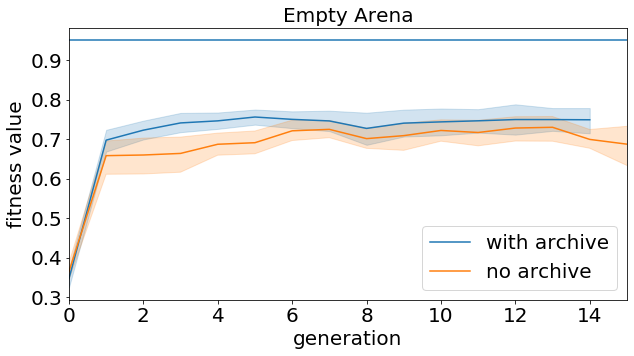

In [28]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_dc_data,x="generation",y="average fitness",label="with archive")
sns.lineplot(data=na_dc_data,x="generation",y="average fitness",label="no archive")
ax.set_ylabel("fitness value")
ax.axhline(y=0.95)
ax.set_xlim([0,15])
ax.set_xticks(range(0,15,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

380
MannwhitneyuResult(statistic=44.0, pvalue=2.1736938768616632e-05)
380
MannwhitneyuResult(statistic=70.0, pvalue=0.0003930259877974254)


Text(8, 0.55, 'Statistic : 70.0\np : 0.00039')

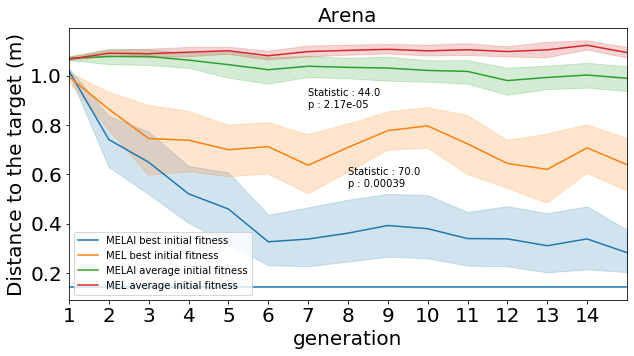

In [29]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best initial fitness",label="MELAI best initial fitness")
sns.lineplot(data=na_dc_data,x="generation",y="best initial fitness",label="MEL best initial fitness")
sns.lineplot(data=wa_dc_data,x="generation",y="average initial fitness",label="MELAI average initial fitness")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average initial fitness",label="MEL average initial fitness")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15))
ax.axhline(y=(1-0.95)*math.sqrt(2**3))

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("Distance to the target (m)")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(fontsize=10,bbox_to_anchor=(1.,0.5,0,0))
d1 = wa_dc_data[wa_dc_data["generation"]==15]["best initial fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==15]["best initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
U1, p = spstat.mannwhitneyu(d1,d2)
stat = "Statistic : " + str(U1) + "\np : " + str(round(p,7))
plt.text(7,0.87,stat,fontsize=10)
d1 = wa_dc_data[wa_dc_data["generation"]==15]["average initial fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==15]["average initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
U1, p = spstat.mannwhitneyu(d1,d2)
stat = "Statistic : " + str(U1) + "\np : " + str(round(p,5))
plt.text(8,0.55,stat,fontsize=10)

380
MannwhitneyuResult(statistic=86.5, pvalue=0.0018997635826920759)


Text(2, 2700, 'Statistic : 86.5\np : 0.0019')

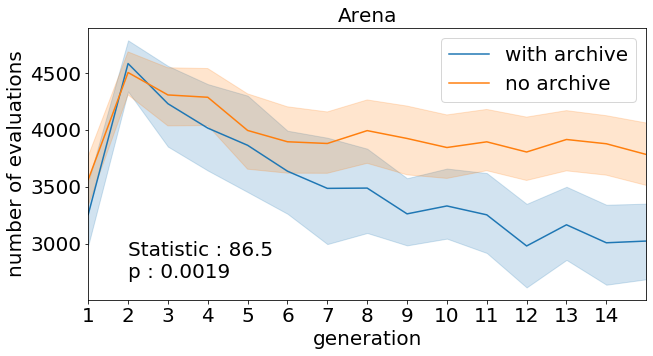

In [30]:
fig = plt.gcf()
fig.set_size_inches(10,5 )
sns.lineplot(data=wa_dc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
d1 = wa_dc_data[wa_dc_data["generation"]==15]["number of evaluations"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==15]["number of evaluations"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
U1, p = spstat.mannwhitneyu(d1,d2)
stat = "Statistic : " + str(U1) + "\np : " + str(round(p,4))
plt.text(2,2700,stat,fontsize=20)

342
MannwhitneyuResult(statistic=116.0, pvalue=0.0488425007259649)


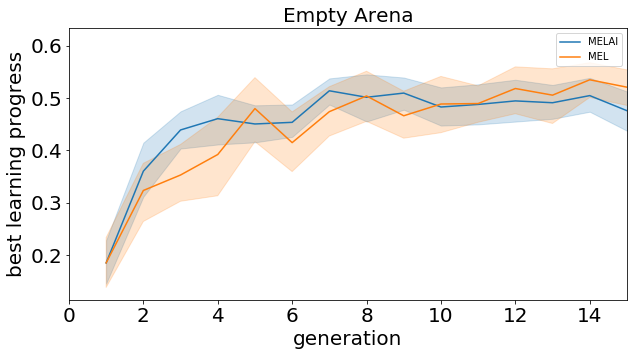

In [78]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best learning progress",label="MEL")
d1 = wa_dc_data[wa_dc_data["generation"]==15]["best learning progress"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==15]["best learning progress"].to_numpy()
ax.set_xlim([0,15])
ax.set_xticks(range(0,15,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title(arena,fontsize=20)
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

400
MannwhitneyuResult(statistic=160.0, pvalue=0.142652357953844)


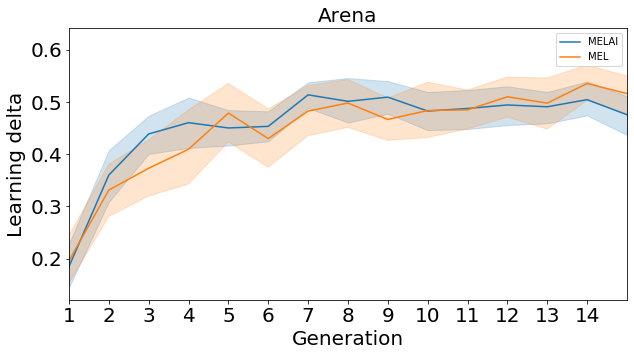

In [23]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best learning progress",label="MEL")
d1 = wa_dc_data[wa_dc_data["generation"]==14]["best learning progress"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==14]["best learning progress"].to_numpy()
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_xlim(1,15)
ax.set_xticks(range(1,15))
ax.set_ylabel("Learning delta")
ax.set_xlabel("Generation")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title(arena,fontsize=20)
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))

Text(0.5, 1.0, 'Empty Arena')

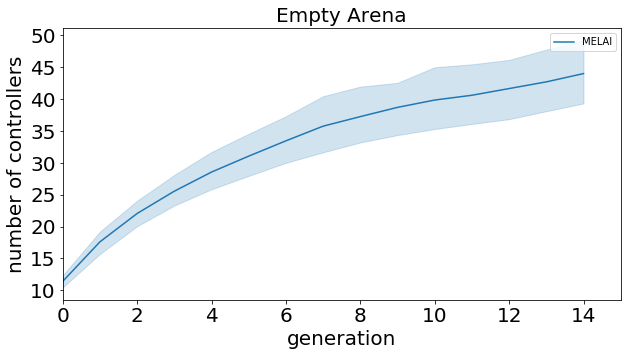

In [32]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax = sns.lineplot(data=wa_dc_data,x="generation",y="number of controllers",label="MELAI")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_xlim([0,15])
ax.set_xticks(range(0,15,2))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title(arena,fontsize=20)

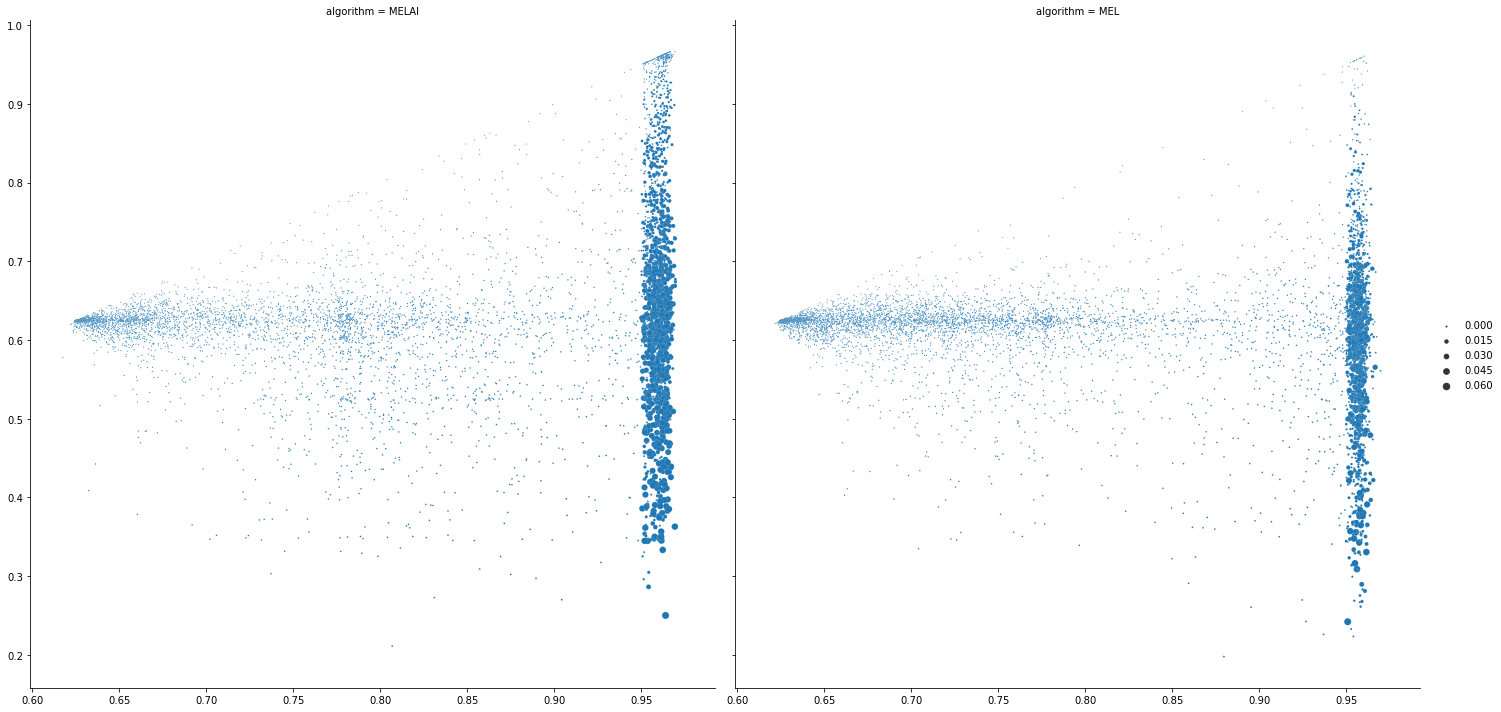

In [33]:
g = sns.FacetGrid(data=dc_data2,col="algorithm",height=10)
g.map_dataframe(sns.scatterplot,x="fitness",y="initial fitness",size="learning progress",sizes=(1,50))
g.add_legend()

Text(0.5, 0.98, 'Arena')

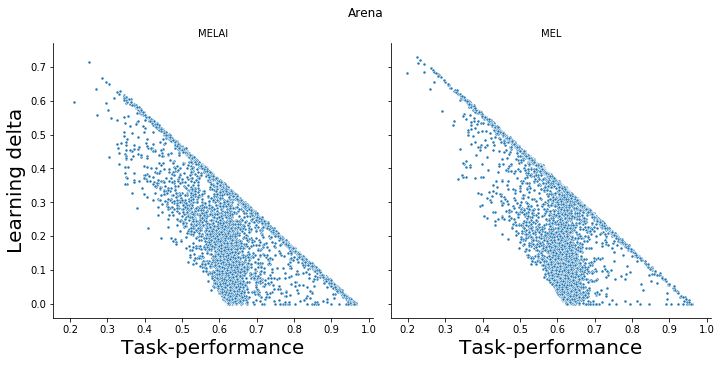

In [95]:
g = sns.FacetGrid(data=dc_data2,col="algorithm",height=5)
g.map_dataframe(sns.scatterplot,"initial fitness","learning progress",marker='.')
g.set_xlabels("Task-performance",fontsize=20)
g.set_ylabels("Learning delta",fontsize=20)
g.set_titles("{col_name}",fontsize=40)
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle(arena)

## Diversity of robots type

In [169]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])

        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    #if(fit[2] >= 0.5):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MELAI",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MELAI",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MELAI",arena])

In [149]:
fit_lines_na = []
desc_lines_na = []
type_lines_na = []
best_desc_lines_na = []
for folder in os.listdir(exp_folder_na):
    descriptors = load_descriptor(exp_folder_na + folder + "/MD_Cart_WDH.csv")
    type_lines_na += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder_na + folder + "/fitnesses.csv",0)
    fit_lines_na += fitnesses
    best_desc_lines_na += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines_na.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines_na,desc_lines_na):
    #if(fit[2] >= 0.5):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL",arena])

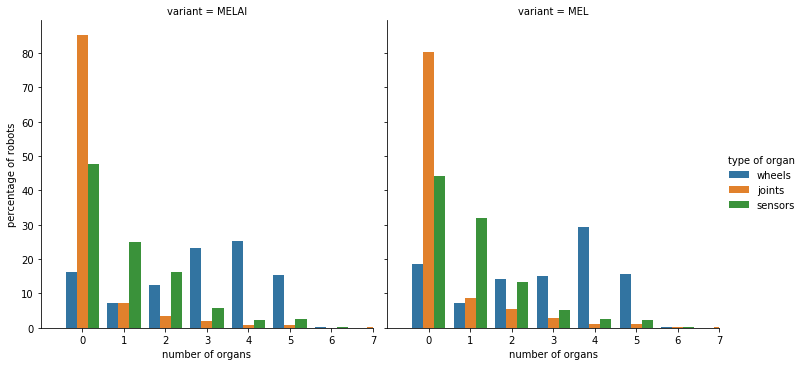

In [107]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

[[3, 0, 2], [4, 0, 1], [3, 0, 1], [4, 0, 1], [3, 0, 2], [3, 0, 1], [4, 0, 1], [3, 0, 2], [4, 0, 1], [4, 0, 1], [4, 0, 1], [3, 0, 1], [3, 0, 1], [4, 0, 0], [3, 0, 0], [4, 1, 1], [4, 0, 1], [4, 0, 1], [2, 0, 2]]


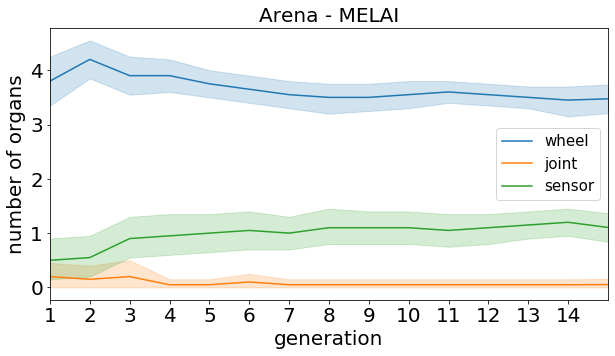

In [108]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15))#ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MELAI",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==15]["wheel"].values
joints_array = data.loc[data["generation"]==15]["joint"].values
sensors_array = data.loc[data["generation"]==15]["sensor"].values
bda = [[w,j,s]for w,j,s in zip(wheels_array,joints_array,sensors_array)]
print(bda)

[[4, 0, 1], [4, 0, 1], [3, 0, 2], [4, 0, 1], [4, 0, 2], [4, 0, 1], [4, 0, 0], [3, 0, 2], [4, 0, 1], [4, 0, 1], [4, 0, 1], [2, 1, 1], [4, 0, 1], [4, 0, 1], [4, 0, 1], [4, 0, 1], [4, 0, 1], [3, 1, 1]]


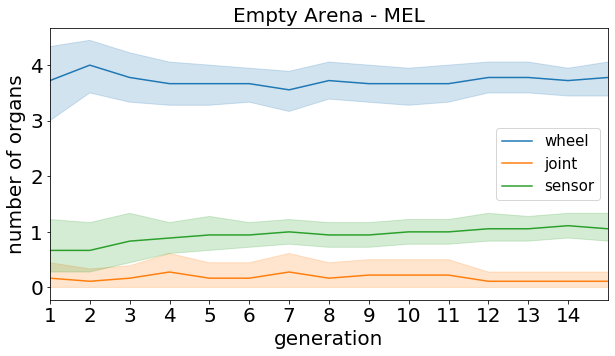

In [163]:
data = pd.DataFrame(data=best_desc_lines_na,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15))
#ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MEL",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==14]["wheel"].values
joints_array = data.loc[data["generation"]==14]["joint"].values
sensors_array = data.loc[data["generation"]==14]["sensor"].values
bda = [[w,j,s]for w,j,s in zip(wheels_array,joints_array,sensors_array)]
print(bda)

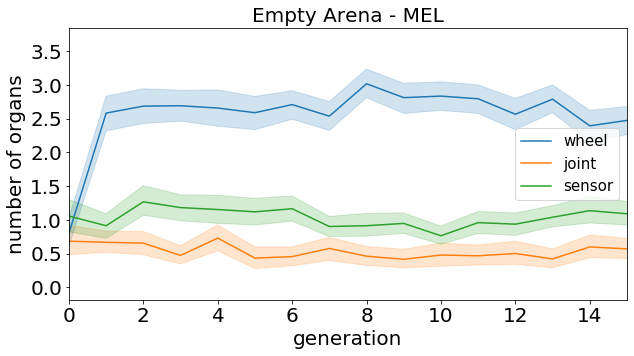

In [61]:
data = pd.DataFrame(data=desc_lines,columns=["generation","individual","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xlim([0,15])
ax.set_xticks(range(0,15,2))
#ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MEL",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

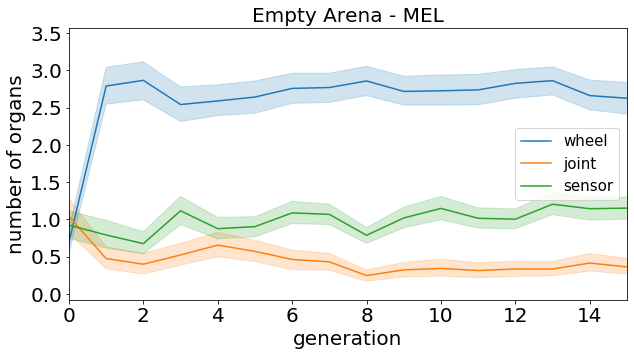

In [62]:
data = pd.DataFrame(data=desc_lines_na,columns=["generation","individual","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xlim([0,15])
ax.set_xticks(range(0,15,2))
#ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MEL",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

# Escape Room

In [34]:
nb_eval_lines = []

In [35]:
arena="Escape Room"
exp_folder = "/home/leni/are-logs/mnipes_escape_tcds/wa/"
exp_folder_na = "/home/leni/are-logs/mnipes_escape_tcds/na/"

In [36]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit),3)
   
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"with archive 200",bff_ne,acc_nbr_eval[-1]])
    
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    #descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    #fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    #for i in range(len(fitnesses)):
    #    fitnesses[i][2] = init_f[fitnesses[i][0]][fitnesses[i][1]]
    #fit_per_desc = fitness_per_descriptor(descriptors,fitnesses)
    fit_diff_ctrl_v = []
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(int(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=[]
        diff_fit=[]
        for i,line in ctrl_arch.iterrows():
            organ_desc = str(int(line["number of wheels"])) + str(int(line["number of sensors"])) + str(int(line["number of joints"]))
            
            
            #if(organ_desc in fit_per_desc[gen_v[-1]]):
            #    for fit in fit_per_desc[gen_v[-1]][organ_desc]:
            #        diff_fit.append(1 - abs(fit - line["fitness"]))
            if(line["fitness"] > 0):
                nbr_ctrl+=1
                ctrl_fit.append(line["fitness"])
            
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit)
        fit_diff_ctrl_v.append(diff_fit)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    ctrl_fit_v = [ctrl_fit_v[i] for i in np.argsort(gen_v)]
    fit_diff_ctrl_v = [fit_diff_ctrl_v[i] for i in np.argsort(gen_v)]
    
    print(acc_nbr_eval[-1])

    for gen, bf,initf, af, nc,cf,ane,ne,ld,lp in zip(range(len(best_fit)),best_fit, init_f,avg_fit,nbr_ctrl_v,ctrl_fit_v,acc_nbr_eval,nbr_eval,learn_delta,learn_prog):
        lines.append([gen+1,
                      gen*25*200,
                      (1-bf)*math.sqrt(2**3),
                      (1-np.mean(initf))*math.sqrt(2**3),
                      (1-np.max(initf))*math.sqrt(2**3),
                      af,
                      ane,
                      nc,
                      (1-np.mean(cf))*math.sqrt(2**3),
                      (1-np.max(cf))*math.sqrt(2**3),
                      ne,
                      np.mean(ld),
                      np.max(ld),
                      np.mean(lp)*math.sqrt(2**3),
                      np.max(lp)*math.sqrt(2**3)])
wa_dc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of controllers",
                                              "average archive controllers fitness",
                                              "best archive controllers fitness",
                                              "number of evaluations",
                                              "average learning delta",
                                              "best learning delta",
                                              "average learning progress",
                                              "best learning progress"])

mnipes_5_7_7-56-38-8064-3825116865
15
60650
mnipes_16_7_11-4-18-8499-2107297851
15
62030
mnipes_18_7_9-16-53-3706-850734008
15
58270
mnipes_14_6_9-24-50-437-132630913
15
67060
mnipes_5_7_10-37-30-472-1808389450
15
47430
mnipes_16_7_11-4-17-7990-1499594641
15
65320
mnipes_14_6_5-44-12-2808-1531187193
15
65300
mnipes_18_7_9-16-59-9713-1515901433
15
60870
mnipes_7_7_16-30-37-7824-3797508763
15
51220
mnipes_14_6_9-26-45-5684-2400249666
15
49590
mnipes_7_7_16-30-51-1317-3039240794
15
55930
mnipes_11_7_1-2-37-7070-2075879755
15
52170
mnipes_14_6_9-24-46-6042-769318560
15
72760
mnipes_11_7_17-2-24-4257-3731275339
15
46430
mnipes_16_7_11-4-28-8921-673961912
15
59400
mnipes_5_7_8-52-59-9186-2316582038
15
56220
mnipes_16_7_11-4-21-1266-3185643078
15
47260
mnipes_14_6_6-17-50-731-2641969643
15
66740
mnipes_14_6_7-0-27-7310-1579005530
15
61990
mnipes_14_6_9-24-47-7701-2778745562
15
73090


In [37]:
lines = []
for folder in os.listdir(exp_folder_na):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder_na + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder_na + folder,len(best_fit),3)
    
    acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nb_eval_lines.append([arena,"no archive 200",bff_ne,acc_nbr_eval[-1]])
            
    print(acc_nbr_eval[-1])
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder_na + folder + "/",len(best_fit))

    for gen, bf, initf, af,ane,ne,ld,lp in zip(range(len(best_fit)),best_fit,init_f,avg_fit,acc_nbr_eval,nbr_eval,learn_delta,learn_prog):
        lines.append([gen+1,
                      gen*2000,
                      (1-bf)*math.sqrt(2**3),
                      (1-np.mean(initf))*math.sqrt(2**3),
                      (1-np.max(initf))*math.sqrt(2**3),
                      af,
                      ane,
                      ne,
                      np.mean(ld),
                      np.max(ld),
                      np.mean(lp)*math.sqrt(2**3),
                      np.max(lp)*math.sqrt(2**3)])
na_dc_data = pd.DataFrame(data=lines,columns=["generation",
                                              "max number of evaluations",
                                              "best fitness",
                                              "average initial fitness",
                                              "best initial fitness",
                                              "average fitness",
                                              "evaluations",
                                              "number of evaluations",
                                              "average learning delta",
                                              "best learning delta",
                                              "average learning progress",
                                              "best learning progress"])

mnipes_11_7_0-55-2-2667-594683783
15
71900
mnipes_21_6_11-22-9-9043-1275807102
15
62750
mnipes_5_7_6-59-18-8513-2911162570
15
59860
mnipes_19_6_0-7-36-6336-1692732661
15
73430
mnipes_16_7_11-5-49-9511-1863946403
15
66110
mnipes_5_7_4-52-59-9368-3311575433
15
58680
mnipes_16_7_11-3-48-8548-2984207292
15
65880
mnipes_21_6_11-21-52-2360-1738360446
15
69730
mnipes_11_7_0-50-56-6205-2939175574
15
70485
mnipes_16_7_11-3-45-5380-2351869195
15
66420
mnipes_5_7_5-29-57-7128-949002531
15
69300
mnipes_5_7_5-1-53-3913-3807766011
15
64810
mnipes_21_6_11-21-58-8078-2236260226
15
62490
mnipes_16_7_11-3-40-149-1080705360
15
67660
mnipes_11_7_10-6-31-1454-1502531099
15
62280
mnipes_10_7_23-41-18-8553-3169759505
15
65650
mnipes_16_7_11-3-30-552-2302914611
15
67180
mnipes_19_6_0-34-6-6080-3555565932
15
66960
mnipes_18_6_20-51-7-7743-4077635574
15
70560
mnipes_5_7_5-0-26-7003-2395433733
15
68570
mnipes_19_6_1-12-51-1162-1920545182
12
57060


In [38]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",20)
    for initf, fit, ld, lp in zip(init_f, best_f, learn_delta,learn_prog):
        for i, f, d, p in zip(initf, fit, ld, lp):
            lines.append([i, f, d, p,"MELAI"])

mnipes_5_7_7-56-38-8064-3825116865
mnipes_16_7_11-4-18-8499-2107297851
mnipes_18_7_9-16-53-3706-850734008
mnipes_14_6_9-24-50-437-132630913
mnipes_5_7_10-37-30-472-1808389450
mnipes_16_7_11-4-17-7990-1499594641
mnipes_14_6_5-44-12-2808-1531187193
mnipes_18_7_9-16-59-9713-1515901433
mnipes_7_7_16-30-37-7824-3797508763
mnipes_14_6_9-26-45-5684-2400249666
mnipes_7_7_16-30-51-1317-3039240794
mnipes_11_7_1-2-37-7070-2075879755
mnipes_14_6_9-24-46-6042-769318560
mnipes_11_7_17-2-24-4257-3731275339
mnipes_16_7_11-4-28-8921-673961912
mnipes_5_7_8-52-59-9186-2316582038
mnipes_16_7_11-4-21-1266-3185643078
mnipes_14_6_6-17-50-731-2641969643
mnipes_14_6_7-0-27-7310-1579005530
mnipes_14_6_9-24-47-7701-2778745562


In [39]:
for folder in os.listdir(exp_folder_na):
    print(folder)
    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder_na + folder + "/",20)
    for initf, fit, ld, lp in zip(init_f, best_f, learn_delta, learn_prog):
        for i, f, d, p in zip(initf, fit, ld, lp):
            lines.append([i, f, d, p,"MEL"])
dc_data2 = pd.DataFrame(data=lines, columns=["initial fitness","fitness", "learning delta", "learning progress","algorithm"])

mnipes_11_7_0-55-2-2667-594683783
mnipes_21_6_11-22-9-9043-1275807102
mnipes_5_7_6-59-18-8513-2911162570
mnipes_19_6_0-7-36-6336-1692732661
mnipes_16_7_11-5-49-9511-1863946403
mnipes_5_7_4-52-59-9368-3311575433
mnipes_16_7_11-3-48-8548-2984207292
mnipes_21_6_11-21-52-2360-1738360446
mnipes_11_7_0-50-56-6205-2939175574
mnipes_16_7_11-3-45-5380-2351869195
mnipes_5_7_5-29-57-7128-949002531
mnipes_5_7_5-1-53-3913-3807766011
mnipes_21_6_11-21-58-8078-2236260226
mnipes_16_7_11-3-40-149-1080705360
mnipes_11_7_10-6-31-1454-1502531099
mnipes_10_7_23-41-18-8553-3169759505
mnipes_16_7_11-3-30-552-2302914611
mnipes_19_6_0-34-6-6080-3555565932
mnipes_18_6_20-51-7-7743-4077635574
mnipes_5_7_5-0-26-7003-2395433733
mnipes_19_6_1-12-51-1162-1920545182


## controller archive dynamics

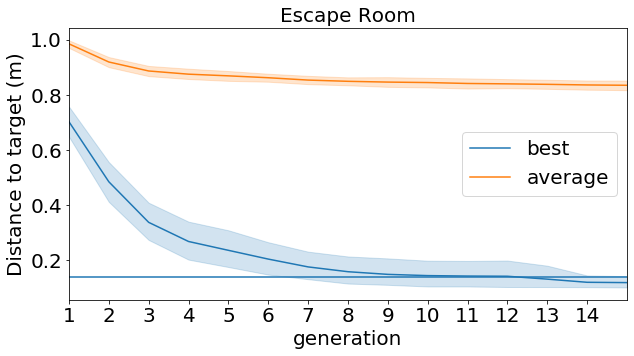

In [150]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_dc_data,x="generation",y="best archive controllers fitness",label="best")
sns.lineplot(data=wa_dc_data,x="generation",y="average archive controllers fitness",label="average")
ax.set_ylabel("Distance to target (m)")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15))
ax.axhline(y=0.05*math.sqrt(2**3))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

(array([10, 20, 30, 40, 50]), <a list of 5 Text yticklabel objects>)

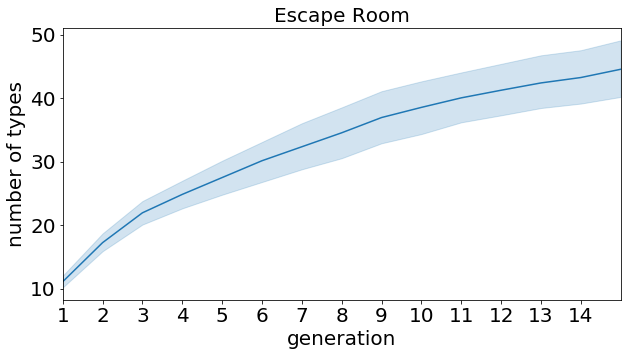

In [40]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_dc_data,x="generation",y="number of controllers")
ax.set_ylabel("number of types")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15))
ax.set_yticks(range(10,51,10))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## Performance

400
MannwhitneyuResult(statistic=117.0, pvalue=0.01281963600440279)


Text(5, 0.5, 'Statistic : 117.0\np : 0.013')

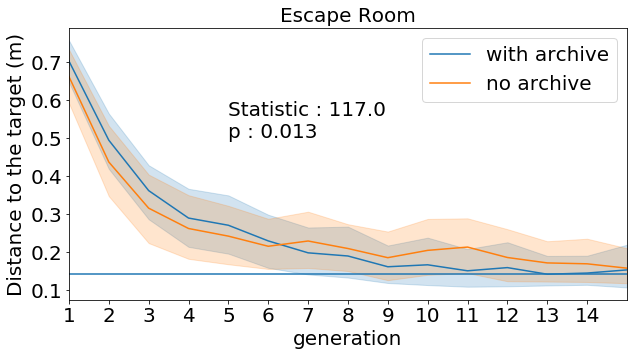

In [41]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_dc_data,x="generation",y="best fitness",label="with archive")
sns.lineplot(data=na_dc_data,x="generation",y="best fitness",label="no archive")
ax.set_ylabel("Distance to the target (m)")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15))
ax.axhline(y=0.05*math.sqrt(2**3))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
d1 = wa_dc_data[wa_dc_data["generation"]==15]["best fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==15]["best fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
U1, p = spstat.mannwhitneyu(d1,d2)
stat = "Statistic : " + str(U1) + "\np : " + str(round(p,3))
plt.text(5,0.5,stat,fontsize=20)

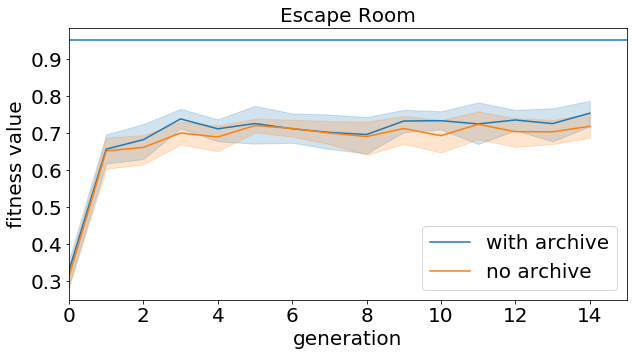

In [8]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_dc_data,x="generation",y="average fitness",label="with archive")
sns.lineplot(data=na_dc_data,x="generation",y="average fitness",label="no archive")
ax.set_ylabel("fitness value")
ax.axhline(y=0.95)
ax.set_xlim([0,15])
ax.set_xticks(range(0,15,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

400
MannwhitneyuResult(statistic=21.0, pvalue=6.880308194350132e-07)
400
MannwhitneyuResult(statistic=63.0, pvalue=0.00011110131006840324)


Text(11, 0.58, 'Statistic : 63.0\np : 0.00011')

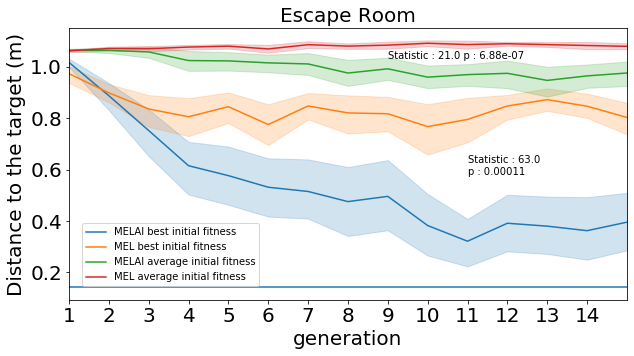

In [42]:
fig = plt.gcf()
fig.set_size_inches(10,5)
sns.lineplot(data=wa_dc_data,x="generation",y="best initial fitness",label="MELAI best initial fitness")
sns.lineplot(data=na_dc_data,x="generation",y="best initial fitness",label="MEL best initial fitness")
sns.lineplot(data=wa_dc_data,x="generation",y="average initial fitness",label="MELAI average initial fitness")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average initial fitness",label="MEL average initial fitness")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15))
ax.axhline(y=0.05*math.sqrt(2**3))

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("Distance to the target (m)")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=10,bbox_to_anchor=(0.35,0.3,0,0))
d1 = wa_dc_data[wa_dc_data["generation"]==13]["best initial fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==13]["best initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
U1, p = spstat.mannwhitneyu(d1,d2)
stat = "Statistic : " + str(U1) + " p : " + str(round(p,9))
plt.text(9,1.03,stat,fontsize=10)
d1 = wa_dc_data[wa_dc_data["generation"]==13]["average initial fitness"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==13]["average initial fitness"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
U1, p = spstat.mannwhitneyu(d1,d2)
stat = "Statistic : " + str(U1) + "\np : " + str(round(p,5))
plt.text(11,0.58,stat,fontsize=10)

400
MannwhitneyuResult(statistic=90.5, pvalue=0.0015953803474530745)


Text(2, 3250, 'Statistic : 90.5\np : 0.0016')

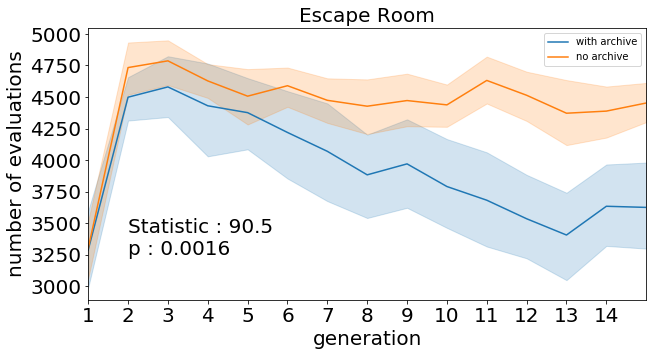

In [43]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
d1 = wa_dc_data[wa_dc_data["generation"]==15]["number of evaluations"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==15]["number of evaluations"].to_numpy()
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
U1, p = spstat.mannwhitneyu(d1,d2)
stat = "Statistic : " + str(U1) + "\np : " + str(round(p,4))
plt.text(2,3250,stat,fontsize=20)

0
MannwhitneyuResult(statistic=0.0, pvalue=0.0)


/usr/lib/python3/dist-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


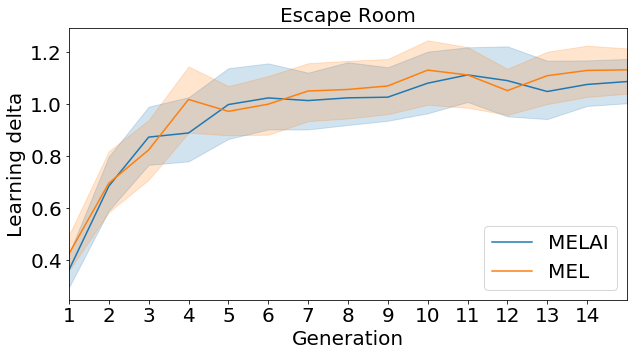

In [30]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="MELAI")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best learning progress",label="MEL")
d1 = wa_dc_data[wa_dc_data["generation"]==19]["best learning progress"].to_numpy()
d2 = na_dc_data[na_dc_data["generation"]==19]["best learning progress"].to_numpy()
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_xlim(1,15)
ax.set_xticks(range(1,15))
ax.set_ylabel("Learning delta")
ax.set_xlabel("Generation")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title(arena,fontsize=20)
print(len(d1)*len(d2))
print(spstat.mannwhitneyu(d1,d2))
plt.legend(fontsize=20)

In [39]:
g = sns.FacetGrid(data=dc_data2,col="algorithm",height=10)
g.map_dataframe(sns.scatterplot,x="fitness",y="initial fitness",size="learning progress",sizes=(1,50))
g.add_legend()

NameError: name 'dc_data2' is not defined

Text(0.5, 0.98, 'Escape Room')

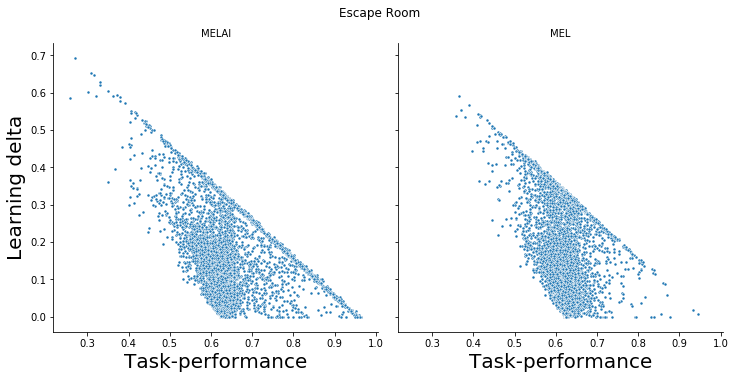

In [142]:
g = sns.FacetGrid(data=dc_data2,col="algorithm",height=5)
g.map_dataframe(sns.scatterplot,x="initial fitness",y="learning progress",marker='.')
g.set_xlabels("Task-performance",fontsize=20)
g.set_ylabels("Learning delta",fontsize=20)
g.set_titles("{col_name}",fontsize=40)
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle(arena)

## Diversity of robots type

In [171]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    #if(fit[2] >= 0.5):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MELAI",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MELAI",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MELAI",arena])

In [152]:
fit_lines_na = []
desc_lines_na = []
type_lines_na = []
best_desc_lines_na = []
for folder in os.listdir(exp_folder_na):
    descriptors = load_descriptor(exp_folder_na + folder + "/MD_Cart_WDH.csv")
    type_lines_na += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder_na + folder + "/fitnesses.csv",0)
    fit_lines_na += fitnesses
    best_desc_lines_na += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines_na.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines_na,desc_lines_na):
    #if(fit[2] >= 0.5):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL",arena])

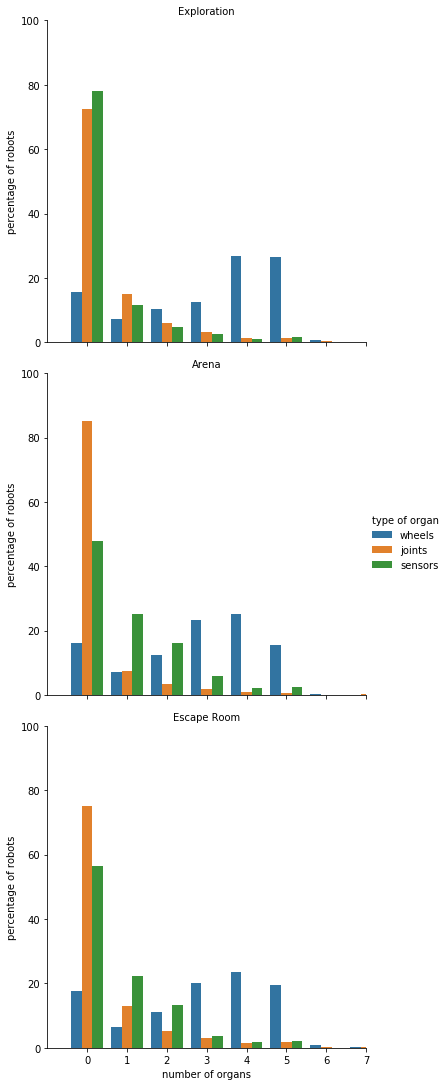

In [173]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant","environment"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",row="environment",kind='bar')
g.set_titles("{row_name}",fontsize=40)
g.set(xlim=[-1,7],ylim=[0,100])

[[4, 0, 0], [4, 0, 0], [3, 1, 1], [5, 0, 0], [4, 0, 1], [3, 0, 2], [4, 0, 0], [3, 1, 1], [4, 0, 1], [4, 0, 1], [4, 0, 1], [4, 0, 1], [4, 1, 0], [3, 0, 2], [4, 0, 1], [2, 0, 1], [4, 0, 1], [5, 0, 2], [4, 0, 1], [5, 0, 0]]


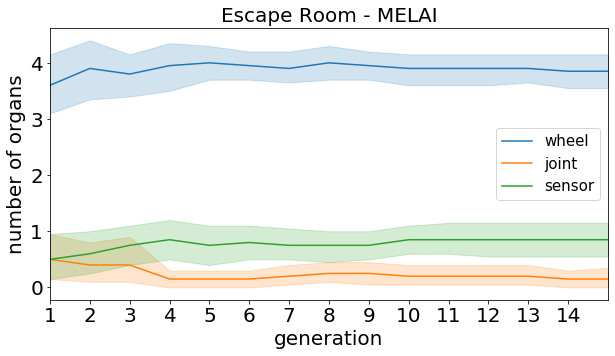

In [148]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xlim([1,15])
ax.set_xticks(range(1,15))#ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MELAI",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==14]["wheel"].values
joints_array = data.loc[data["generation"]==14]["joint"].values
sensors_array = data.loc[data["generation"]==14]["sensor"].values
bda = [[w,j,s]for w,j,s in zip(wheels_array,joints_array,sensors_array)]
print(bda)

[[3, 0, 2], [4, 0, 1], [2, 0, 3], [4, 1, 3], [4, 0, 1], [4, 0, 1], [4, 0, 1], [4, 0, 1], [4, 0, 2], [5, 0, 0], [4, 0, 1], [3, 0, 2], [4, 0, 1], [4, 0, 1], [4, 0, 1], [4, 0, 1], [3, 2, 3], [4, 0, 1], [4, 0, 1], [4, 0, 1]]


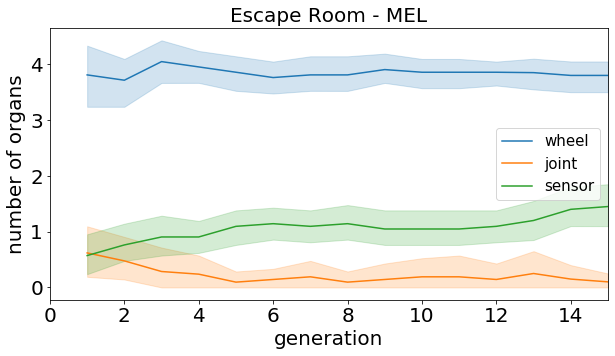

In [114]:
data = pd.DataFrame(data=best_desc_lines_na,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xlim([0,15])
ax.set_xticks(range(0,15,2))
#ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MEL",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==14]["wheel"].values
joints_array = data.loc[data["generation"]==14]["joint"].values
sensors_array = data.loc[data["generation"]==14]["sensor"].values
bda = [[w,j,s]for w,j,s in zip(wheels_array,joints_array,sensors_array)]
print(bda)

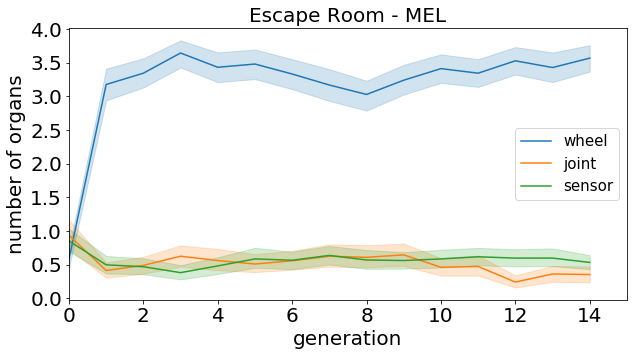

In [23]:
data = pd.DataFrame(data=desc_lines,columns=["generation","individual","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xlim([0,15])
ax.set_xticks(range(0,15,2))
#ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MEL",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

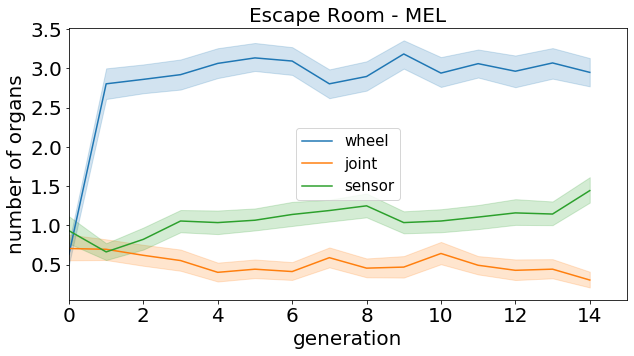

In [24]:
data = pd.DataFrame(data=desc_lines_na,columns=["generation","individual","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xlim([0,15])
ax.set_xticks(range(0,15,2))
#ax.set_yticks(range(5))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena + " - MEL",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)